In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
!pip install geopandas
!pip install geojson
!pip install rasterio
!pip install rasterstats
!pip install treeinterpreter
!pip install lightgbm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 
     |████████████████████████████████| 6.3 MB 37.8 MB/s 
     |████████████████████████████████| 16.7 MB 30.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 53.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tune-sklearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 4.6 MB/s 
     |████████████████████████████████| 54.5 MB 237 kB/s 
     |████████████████████████████████| 4.1 MB 50.7 MB/s 
     |████████████████████████████████| 10.1 MB 57.2 MB/s 
     |████████████████████████████████| 144 kB 72.0 MB/s 
     |████████████████████████████████| 125 kB 17.6 MB/s 
     |████████████████████████████████| 466 kB 65.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.1 MB/s 


In [1]:
from os import path as op
import torch
import torch.nn as nn
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from geojson import dump 
#import lightgbm as lgb

import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/src')

In [2]:
# import our own packages
from prepare_data_for_training_ML_ANN import *
from training_error_analysis import *

In [3]:
raster_path = '/Users/pavelbozmarov/Desktop/Desktop/SPACE INTELLIGENCE/Project_Scotland/data/raster_file' + '/big.tif'
vectors_path = '/Users/pavelbozmarov/Desktop/Desktop/SPACE INTELLIGENCE/Project_Scotland/data/vector_file/Scotland_labels.geojson'

In [6]:
os.chdir('/content/drive/MyDrive/Space_Intelligence/Project_Scotland/data')

In [7]:
raster_path_colab = 'raster_file/big.tif'
vector_path_colab = 'vector_file/Scotland_labels.geojson'

## Feature Engineering

In [4]:
# read in training data polygons that created as geojson
training_vectors = gpd.read_file(vectors_path)
training_vectors.head(10)

LEVEL1            CLASS  numeric_class  \
0      G           Forest              5   
1      G           Forest              5   
2      G           Forest              5   
3      G           Forest              5   
4      G           Forest              5   
5      G           Forest              5   
6      C            Water              1   
7      F  Shrub/Heathland              4   
8      F  Shrub/Heathland              4   
9      F  Shrub/Heathland              4   

                                            geometry  
0  POLYGON ((-3.59427 57.02314, -3.59346 57.02304...  
1  POLYGON ((-3.61092 57.02311, -3.61032 57.02349...  
2  POLYGON ((-3.44058 56.99129, -3.43966 56.99199...  
3  POLYGON ((-3.40925 57.00019, -3.40946 57.00038...  
4  POLYGON ((-3.40857 57.00121, -3.40739 57.00115...  
5  POLYGON ((-3.41239 56.99896, -3.41190 56.99936...  
6  POLYGON ((-4.43966 56.96500, -4.42482 56.97041...  
7  POLYGON ((-3.58935 57.01732, -3.58833 57.01755...  
8  POLYGON ((-4.00820 57.30173, -4.00818 57.30208...  
9  POLYGON ((-3.98153 57.11809, -3.98113 57.11838...

In [7]:
np.unique(training_vectors['numeric_class'],return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([195, 189, 917, 395, 862, 101, 296, 263,  44]))

In [8]:
# we add the index as a column (because of the structure of the following functions)
training_vectors['id'] = np.arange(len(training_vectors['CLASS']))

In [9]:
# Create a new column name which will keep the initial class names
training_vectors['name'] = training_vectors['CLASS']

In [10]:
# check the number of differe classes
# find all unique values of training data names 
np.unique(training_vectors.name)


array(['Agriculture', 'Bare', 'Bogs', 'Built-up', 'Forest', 'Grassland',
       'Shrub/Heathland', 'Water'], dtype=object)

In [11]:
# Check how many different poligons we have per name
print(f"Number of Agriculture Polygons: {len(training_vectors[training_vectors['CLASS']=='Agriculture'])}")
print(f"Number of Bare Polygons: {len(training_vectors[training_vectors['CLASS']=='Bare'])}")
print(f"Number of Bogs Polygons: {len(training_vectors[training_vectors['CLASS']=='Bogs'])}")
print(f"Number of Built-up Polygons: {len(training_vectors[training_vectors['CLASS']=='Built-up'])}")
print(f"Number of Forest Polygons: {len(training_vectors[training_vectors['CLASS']=='Forest'])}")
print(f"Number of Shrub/Heathland Polygons: {len(training_vectors[training_vectors['CLASS']=='Shrub/Heathland'])}")
print(f"Number of Water Polygons: {len(training_vectors[training_vectors['CLASS']=='Water'])}")
print(f"Number of Grassland Polygons: {len(training_vectors[training_vectors['CLASS']=='Grassland'])}")

Number of Agriculture Polygons: 296
Number of Bare Polygons: 145
Number of Bogs Polygons: 189
Number of Built-up Polygons: 263
Number of Forest Polygons: 862
Number of Shrub/Heathland Polygons: 395
Number of Water Polygons: 195
Number of Grassland Polygons: 917


In [12]:
## WE WANT TO MERGE THE NAMES IN CLASSES
# Bares,Bogs -> Bares and Built

merged_classes = []

for class_name in  training_vectors.name: # loop through the names of the vectors

    if class_name in ['Bare','Built-up']:

        merged_classes.append('Bares_and_Built')
    else:
        merged_classes.append(class_name)


# add the this list as new column in the vectors dataset

training_vectors['classes'] = merged_classes

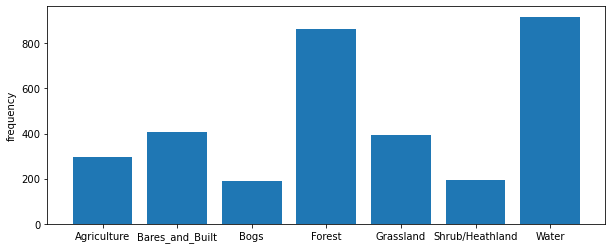

In [17]:
# bar plot
names = np.unique(training_vectors.classes)
frequency = [296,408,189,862,395,195,917]
plt.figure(figsize=(10,4))
plt.bar(names,frequency)
plt.ylabel('frequency')
plt.show()

In [80]:
def test_statistics(test_true,test_predictions,verbose=True):

    '''
    This functions calculates accuracy,balanced_accuracy,f1,recall, and precision.
    input: test_true - the real predicted test values taken from the whole test dataloader,
           test_predictions - predicted values on the whole test dataloader.
    output: results for the statistics
    '''
     
    # the number of samples in our test loader
    n_test = len(list(test_true))

    # calculate the statistics
    bal_acc = balanced_accuracy_score(test_true,test_predictions)
    
    recall = recall_score(test_true,test_predictions,average='weighted')

    precision = precision_score(test_true,test_predictions,average='weighted')

    f1 = f1_score(test_true,test_predictions,average='weighted')
    
    accuracy = accuracy_score(test_true,test_predictions)


    
    if verbose==True:

        print(f'Accuracy:{accuracy}')
        print(f'Balanced Accuracy:{bal_acc}')
        print(f'Recall:{recall}')
        print(f'Precision:{precision}')
        print(f'f1 score:{f1}')


    return bal_acc,recall,precision,f1,accuracy

In [81]:
# we store all the classes in this variable
classes = np.unique(training_vectors['classes'].values)
classes

array(['Agriculture', 'Bares_and_Built', 'Bogs', 'Forest', 'Grassland',
       'Shrub/Heathland', 'Water'], dtype=object)

In [82]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict  

{'Agriculture': 0,
 'Bares_and_Built': 1,
 'Bogs': 2,
 'Forest': 3,
 'Grassland': 4,
 'Shrub/Heathland': 5,
 'Water': 6}

In [83]:
# update the numeric_class variable
ids=[]
for klass in training_vectors['classes']:

    ids.append(class_dict[klass])

training_vectors['numeric_class'] = ids


In [84]:
# remove the column CLASS as we don't need it anymore
training_vectors = training_vectors.drop(['CLASS'],axis=1)


In [85]:
training_vectors.head(10)

LEVEL1  numeric_class                                           geometry  \
0      G              3  POLYGON ((-3.59427 57.02314, -3.59346 57.02304...   
1      G              3  POLYGON ((-3.61092 57.02311, -3.61032 57.02349...   
2      G              3  POLYGON ((-3.44058 56.99129, -3.43966 56.99199...   
3      G              3  POLYGON ((-3.40925 57.00019, -3.40946 57.00038...   
4      G              3  POLYGON ((-3.40857 57.00121, -3.40739 57.00115...   
5      G              3  POLYGON ((-3.41239 56.99896, -3.41190 56.99936...   
6      C              6  POLYGON ((-4.43966 56.96500, -4.42482 56.97041...   
7      F              5  POLYGON ((-3.58935 57.01732, -3.58833 57.01755...   
8      F              5  POLYGON ((-4.00820 57.30173, -4.00818 57.30208...   
9      F              5  POLYGON ((-3.98153 57.11809, -3.98113 57.11838...   

   id             name          classes  
0   0           Forest           Forest  
1   1           Forest           Forest  
2   2           Forest           Forest  
3   3           Forest           Forest  
4   4           Forest           Forest  
5   5           Forest           Forest  
6   6            Water            Water  
7   7  Shrub/Heathland  Shrub/Heathland  
8   8  Shrub/Heathland  Shrub/Heathland  
9   9  Shrub/Heathland  Shrub/Heathland

In [19]:
# we perform train-test split
np.random.seed(42)
train_set_vectors,test_set_vectors = training_testing_split(training_vectors,test_size=0.25)

In [20]:
# now we rasterize each polygon and perform X_train,y_train,X_test,y_test split
X_train,y_train,X_test,y_test = further_train_test_split(train_set_vectors,test_set_vectors,raster_path_colab,class_dict)

100%|██████████| 818/818 [00:18<00:00, 44.87it/s]


In [ ]:
# check our split
print('y_train')
print(np.unique(y_train,return_counts=True)[0])
print(np.unique(y_train,return_counts=True)[1])
print(' ')
print('y_test')
print(np.unique(y_test,return_counts=True)[0])
print(np.unique(y_test,return_counts=True)[1])
print(' ')
print(class_dict)

y_train
[0 1 2 3 4 5 6]
[51464 23709  9411 75342 46828 16452 17813]
 
y_test
[0 1 2 3 4 5 6]
[18982  4681  3089 21795 16702  6338  4230]
 
{'Agriculture': 0, 'Bares_and_Built': 1, 'Bogs': 2, 'Forest': 3, 'Grassland': 4, 'Shrub/Heathland': 5, 'Water': 6}


In [27]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 1.943105860407275e-05,
 1: 4.2178075836180355e-05,
 2: 0.00010625863351397301,
 3: 1.3272809322821269e-05,
 4: 2.135474502434441e-05,
 5: 6.0782883539995136e-05,
 6: 5.613877505192837e-05}

#Training and Testing Models

In [22]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 209 kB 56.0 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 57.1 MB/s 
     |████████████████████████████████| 147 kB 47.4 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=9a5d1727dd06b65781f491e4fff32f3a782a3d21460dffb95220b57a4a90c10e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


**LGBM MODEL**

In [23]:
import optuna
from sklearn.metrics import log_loss

In [ ]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
   
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 31),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }
   
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    cv_scores = np.empty(4)
    for idx, (train_index, test_index) in enumerate(cv.split(X, y)):
        # we get our training and testing set of vectors
        train_set_vectors =  X.iloc[train_index]
        test_set_vectors = X.iloc[test_index]

        # now we rasterize each polygon and perform X_train,y_train,X_test,y_test split
        X_train,y_train,X_test,y_test = further_train_test_split(train_set_vectors,test_set_vectors,raster_path_colab,class_dict)

        # calculate class weights to allow for training on inbalanced training samples
        labels, counts = np.unique(y_train, return_counts=True)
        class_weight_dict = dict(zip(labels, 1 / counts))

        model = lgb.LGBMClassifier(objective="multiclass", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "multi_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, training_vectors, training_vectors['numeric_class'])
study.optimize(func, n_trials=50)

In [ ]:
print(f"\tBest value (Cross-Entropy): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (Cross-Entropy): 0.44031
	Best params:
		n_estimators: 5000
		learning_rate: 0.27507353527699924
		num_leaves: 1600
		max_depth: 16
		min_data_in_leaf: 5700
		lambda_l1: 10
		lambda_l2: 85
		min_gain_to_split: 0.5077837195223751
		bagging_fraction: 0.5
		bagging_freq: 1
		feature_fraction: 0.6000000000000001


In [25]:
# the best from optuna
# DEFINE THE LGBM
lgbm = lgb.LGBMClassifier(
       objective='multiclass',
       #num_class = len(class_dict),
       #class_weight = class_weight_dict,
       n_estimators=5000,
       learning_rate = 0.27507353527699924,
       num_leaves=1600,
       max_depth=16,
       min_data_in_leaf=5700,
       lambda_l1=10,
       lambda_l2=85,
       min_gain_to_split=0.5077837195223751,
       bagging_fraction=0.5,
       bagging_freq=1,
       feature_fraction=0.6

       )

# FIT THE X_train and y_train
lgbm.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.6,
               lambda_l1=10, lambda_l2=85, learning_rate=0.27507353527699924,
               max_depth=16, min_data_in_leaf=5700,
               min_gain_to_split=0.5077837195223751, n_estimators=5000,
               num_leaves=1600, objective='multiclass')

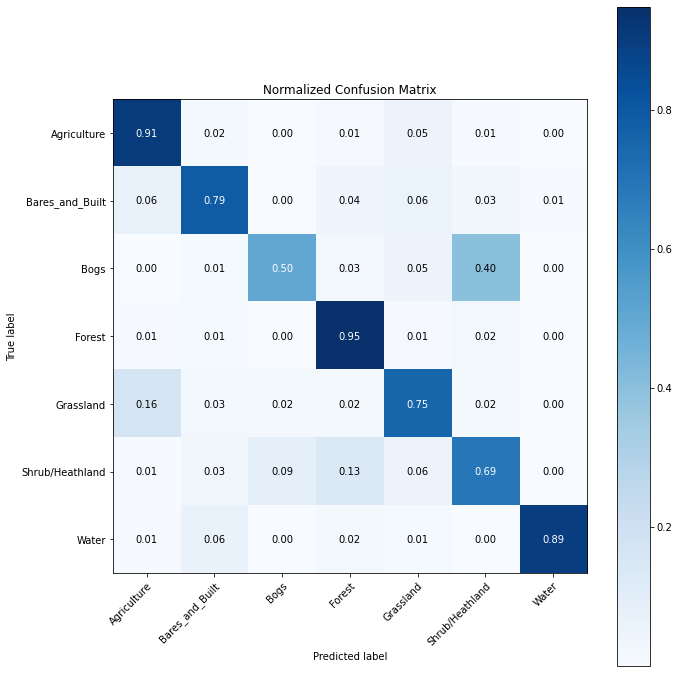

In [28]:
# check our prediction capabilities of the model
preds_lgbm_test = lgbm.predict(X_test)
cm_lgbm_test = confusion_matrix(y_test, preds_lgbm_test, labels=labels)
plot_cm(cm_lgbm_test,classes)

In [34]:
test_statistics(y_test,preds_lgbm_test);

Accuracy:0.8422781170449899
Balanced Accuracy:0.7831788561427346
Recall:0.8422781170449899
Precision:0.8432741918626525
f1 score:0.8410565293445164


In [ ]:
# the best from optuna
# DEFINE THE LGBM
lgbm = lgb.LGBMClassifier(
       objective='multiclass',
       n_estimators=5000,
       num_leaves=1600,
       max_depth=16,
)

# FIT THE X_train and y_train
lgbm.fit(X_train,y_train)

# check our prediction capabilities of the model
preds_lgbm_test = lgbm.predict(X_test)
cm_lgbm_test = confusion_matrix(y_test, preds_lgbm_test, labels=labels)
plot_cm(cm_lgbm_test,classes)
test_statistics(y_test,preds_lgbm_test);



Accuracy:0.8450083754303125
Balanced Accuracy:0.793755016604397
Recall:0.8450083754303125
Precision:0.8448394640247043
f1 score:0.8438737735384302


**RANDOM FOREST MODEL** 

In [ ]:
# This is our best model, found by the GRID SEARCH above.
final_rf = RandomForestClassifier(n_estimators = 400, max_depth = 20,class_weight=class_weight_dict)
final_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1.8439977872026555e-05,
                                     1: 4.5071438229593905e-05,
                                     2: 0.00010854227721697601,
                                     3: 1.4490653528474133e-05,
                                     4: 2.0418163998693237e-05,
                                     5: 5.546927002440648e-05,
                                     6: 8.232485387338437e-05},
                       max_depth=20, n_estimators=400)

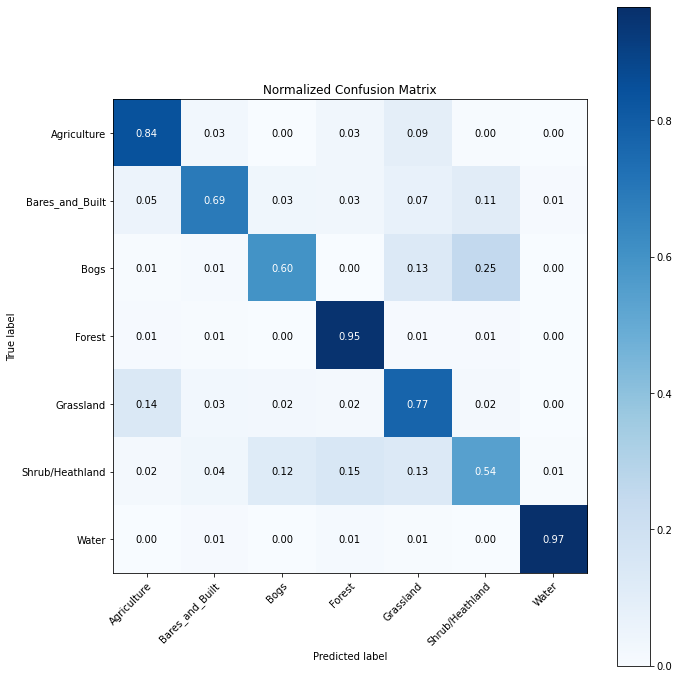

In [ ]:
# predict on X_test to evaluate the model
preds_rf = final_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds_rf, labels=labels)
plot_cm(cm_rf,classes)

In [ ]:
# We see the average balanced accuracy
balanced_accuracy_score(y_test,preds_rf)

0.7659731897131687

**Traditional Gradient Booster**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=500,learning_rate = 0.1,verbose=True)
gbc.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.4560           83.91m
         2           1.3020           76.67m
         3           1.1870           74.40m
         4           1.0961           73.30m
         5           1.0212           72.44m
         6           0.9579           71.97m
         7           0.9034           71.53m
         8           0.8597           71.17m
         9           0.8214           70.91m
        10           0.7892           70.70m
        20           0.6091           68.74m
        30           0.5371           66.84m
        40           0.4972           65.25m
        50           0.4706           63.73m
        60           0.4504           62.29m
        70           0.4333           60.80m
        80           0.4200           59.34m
        90           0.4083           57.96m
       100           0.3981           56.68m
       200           0.3365           42.70m
       300           0.3045           28.45m
       40

GradientBoostingClassifier(n_estimators=500, verbose=True)

In [ ]:
preds_gbc = gbc.predict(X_test)

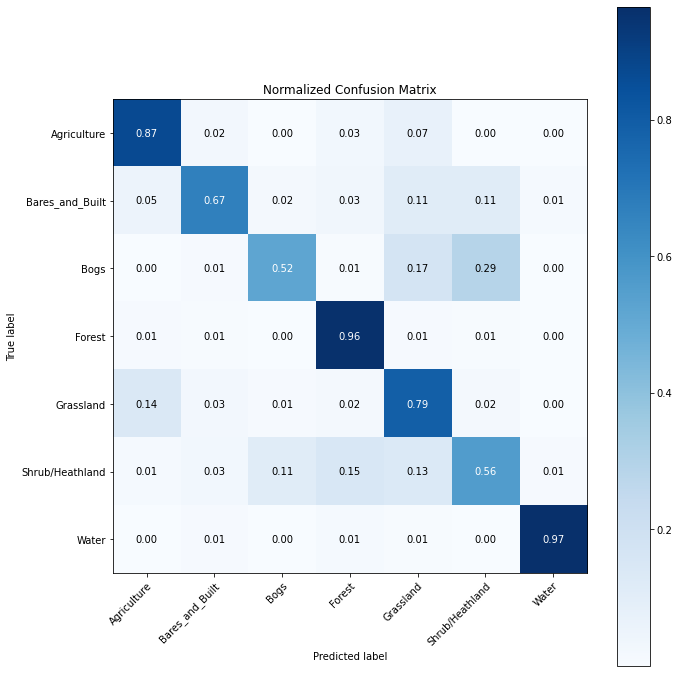

In [ ]:
cm_gbc = confusion_matrix(y_test, preds_gbc, labels=labels)
plot_cm(cm_gbc,classes)

In [ ]:
balanced_accuracy_score(y_test,preds_gbc)

0.7616435286368869

# KFold


**LightGBoost**

In [86]:
cv_model = lgb.LGBMClassifier(
       objective='multiclass',
       #num_class = len(class_dict),
       #class_weight = class_weight_dict,
       n_estimators=5000,
       learning_rate = 0.27507353527699924,
       num_leaves=1600,
       max_depth=16,
       min_data_in_leaf=5700,
       lambda_l1=10,
       lambda_l2=85,
       min_gain_to_split=0.5077837195223751,
       bagging_fraction=0.5,
       bagging_freq=1,
       feature_fraction=0.6

       )

In [94]:
mean_accuracy = []
mean_balanced_accuracy = []
mean_recall = []
mean_prec = []
mean_f1 = []
mean_cm = []

100%|██████████| 816/816 [00:17<00:00, 47.50it/s]


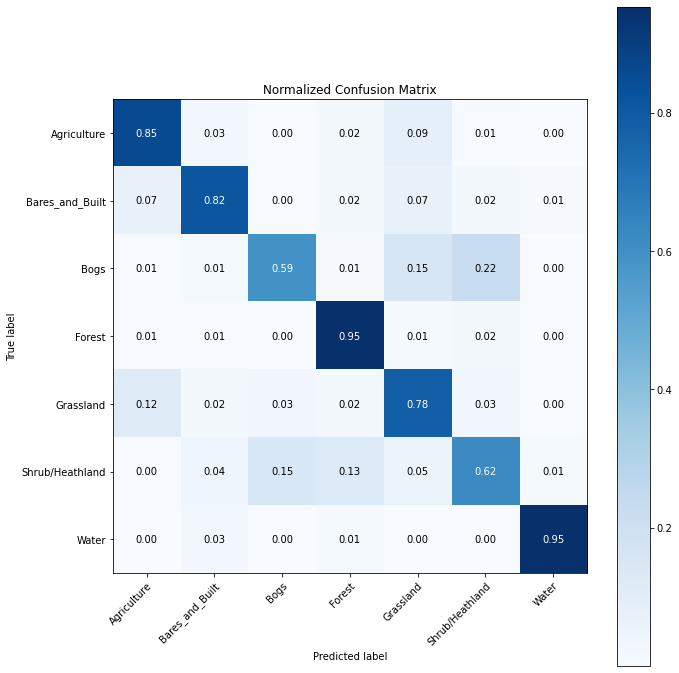

100%|██████████| 816/816 [00:16<00:00, 49.71it/s]


In [ ]:
loops=5
for i in range(loops):
    
    results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm = cross_validate_ml(training_vectors,cv_model,raster_path_colab,class_dict,seed=i,folds=4)
    mean_accuracy.append(results_acc)
    mean_balanced_accuracy.append(results_bal_acc)
    mean_recall.append(results_recall)
    mean_prec.append(results_prec)
    mean_f1.append(results_f1)
    mean_cm.append(results_cm)

print(f'The mean accuracy is:{np.array(mean_accuracy).mean()}')
print(f'The mean balanced accuracy is:{np.array(mean_balanced_accuracy).mean()}')
print(f'The mean precision is:{np.array(mean_prec).mean()}')
print(f'The mean recall is:{np.array(mean_recall).mean()}')
print(f'The mean f1 score is:{np.array(mean_f1).mean()}')

# the final confusion matrix
final_sum_cm = np.zeros(mean_cm[0].shape)
for matrix in mean_cm:
   final_sum_cm +=matrix
final_mean_cm = final_sum_cm/loops

print('FINAL MEAN CONFUSION MATRIX')
plot_cm(final_mean_cm,classes)

**RF Model**

In [86]:
mean_accuracy = []
mean_balanced_accuracy = []
mean_recall = []
mean_prec = []
mean_f1 = []
mean_cm = []

100%|██████████| 816/816 [00:14<00:00, 55.60it/s] 


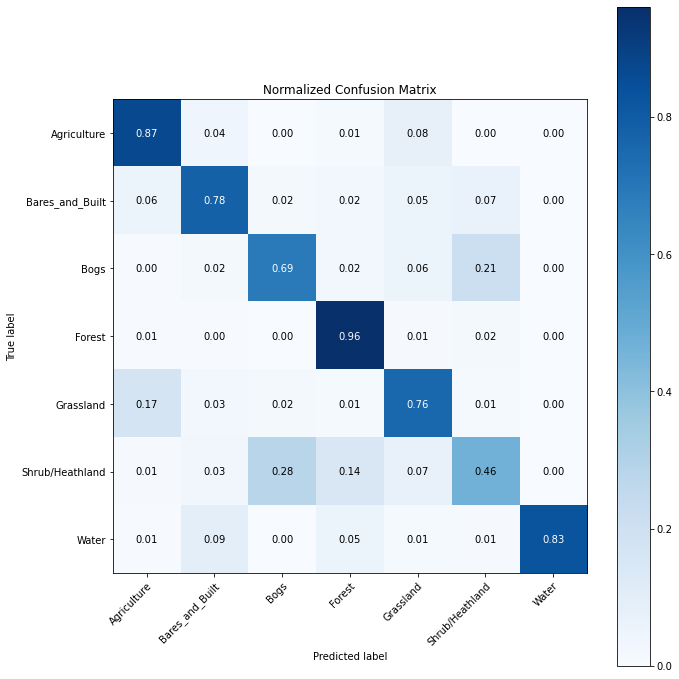

100%|██████████| 816/816 [00:10<00:00, 77.81it/s] 


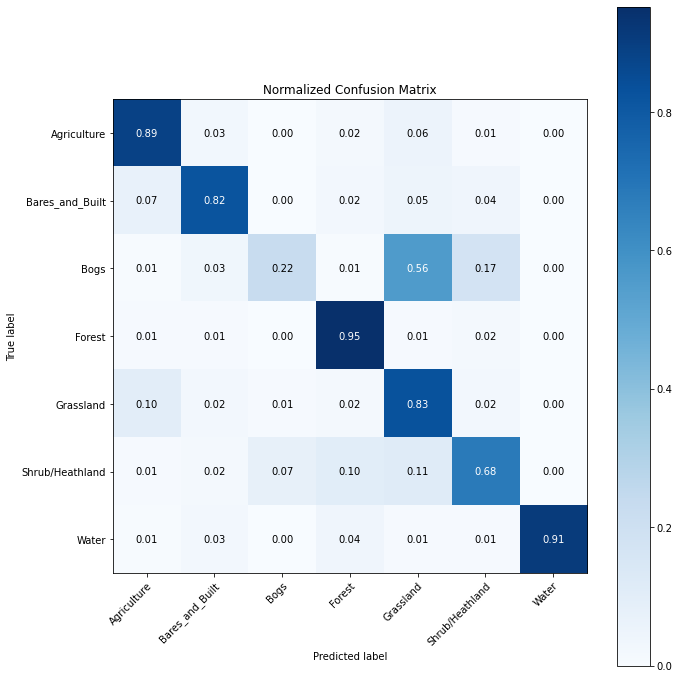

100%|██████████| 815/815 [00:09<00:00, 89.56it/s] 


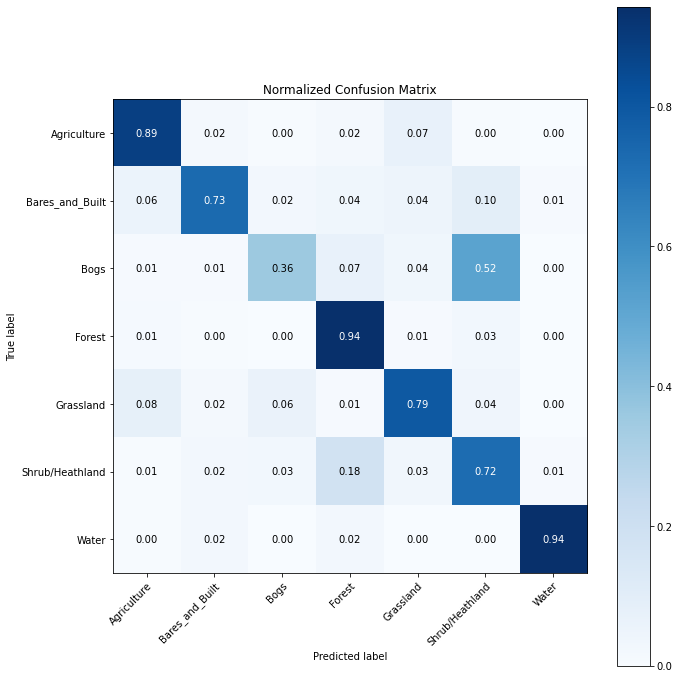

100%|██████████| 815/815 [00:10<00:00, 74.79it/s] 


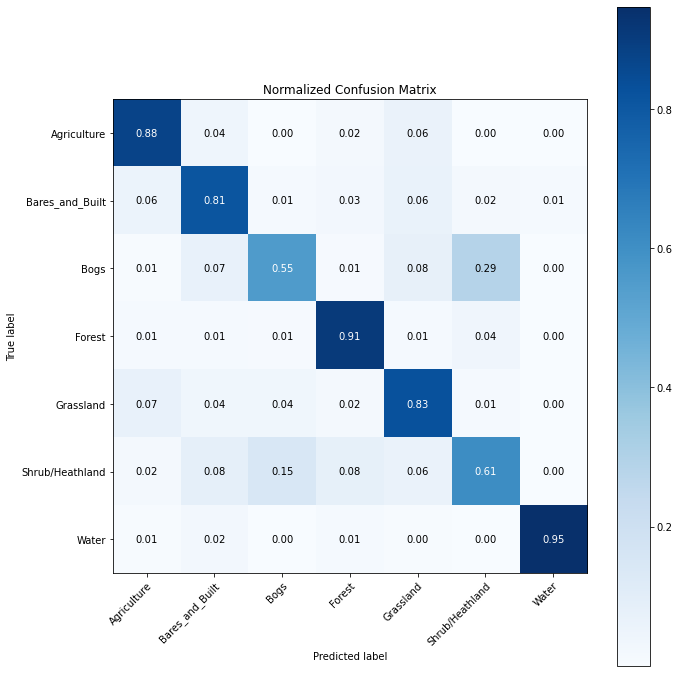

100%|██████████| 816/816 [00:10<00:00, 80.70it/s] 


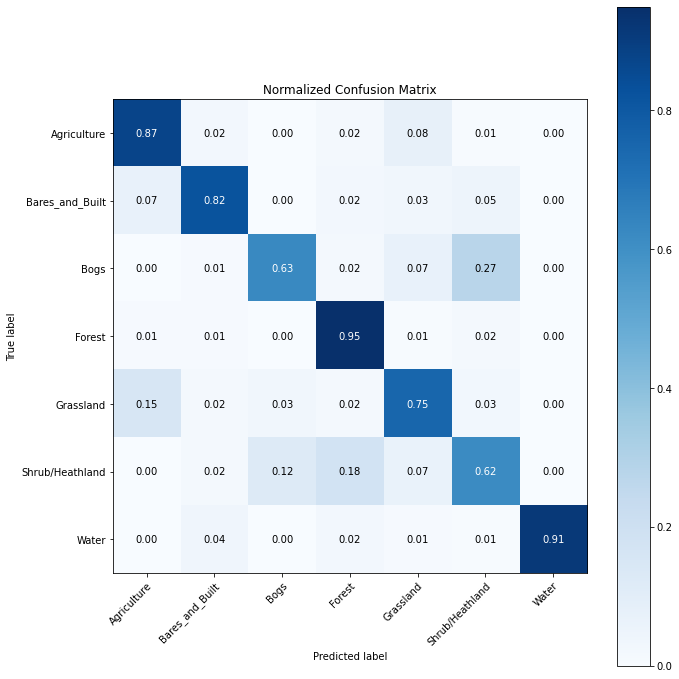

100%|██████████| 816/816 [00:13<00:00, 60.83it/s] 


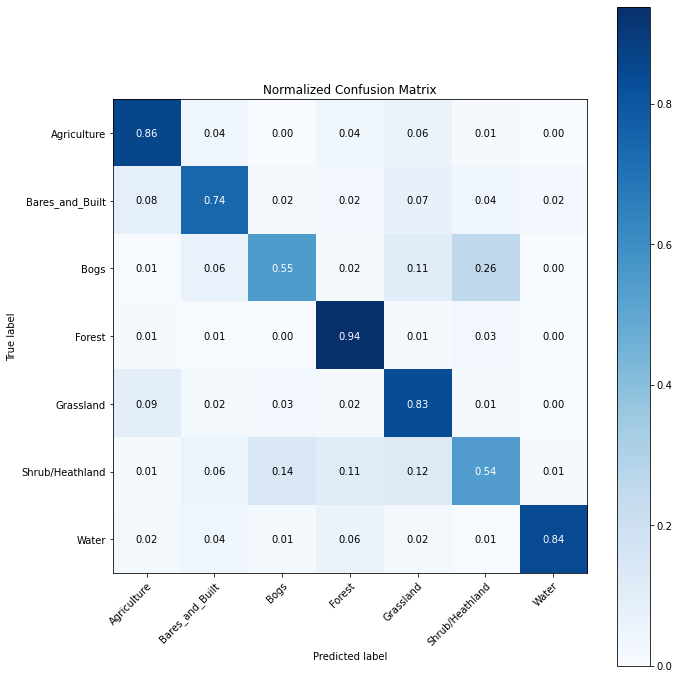

100%|██████████| 815/815 [00:09<00:00, 85.35it/s] 


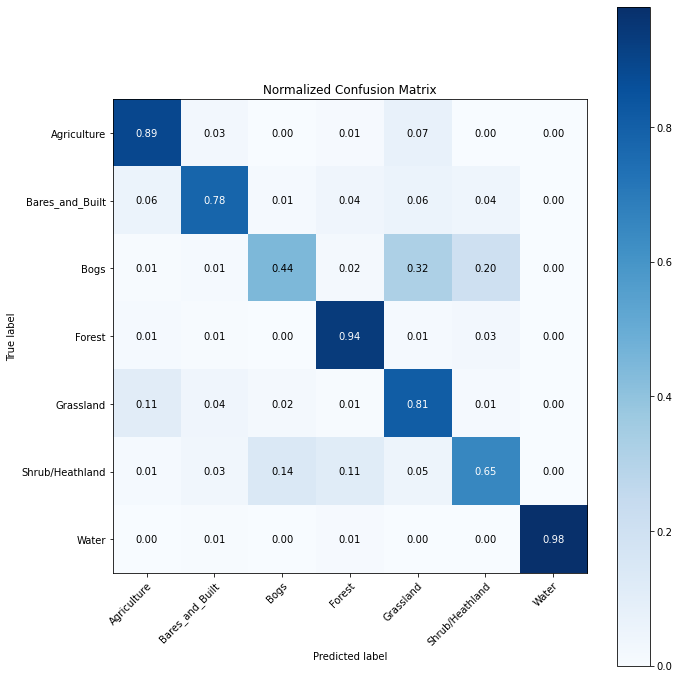

100%|██████████| 815/815 [00:08<00:00, 95.04it/s] 


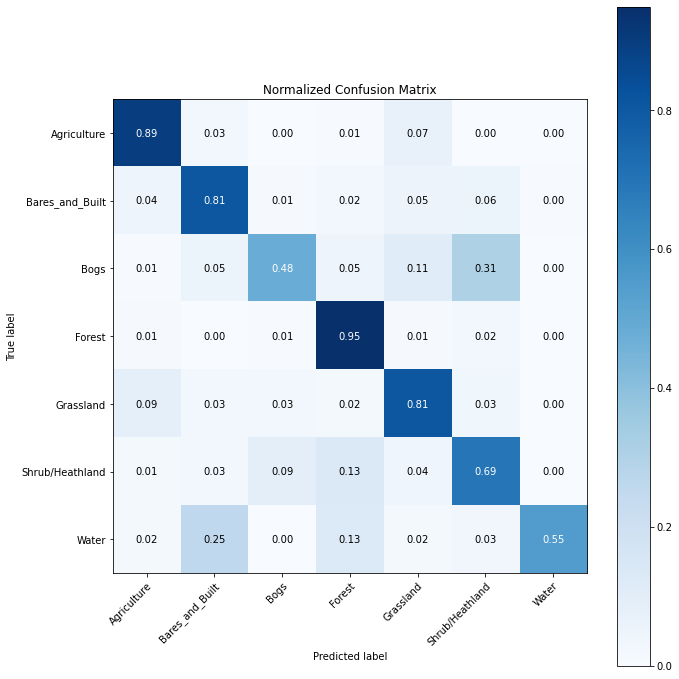

100%|██████████| 816/816 [00:09<00:00, 88.51it/s] 


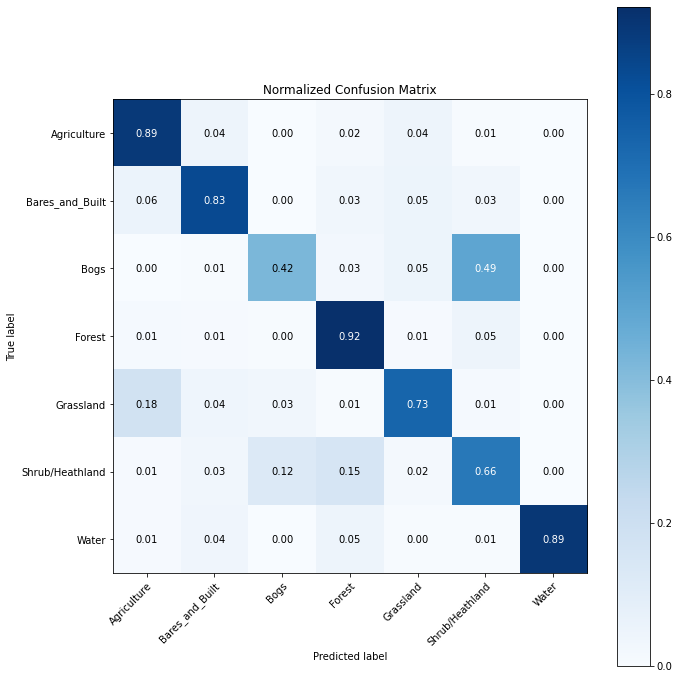

100%|██████████| 816/816 [00:09<00:00, 89.21it/s] 


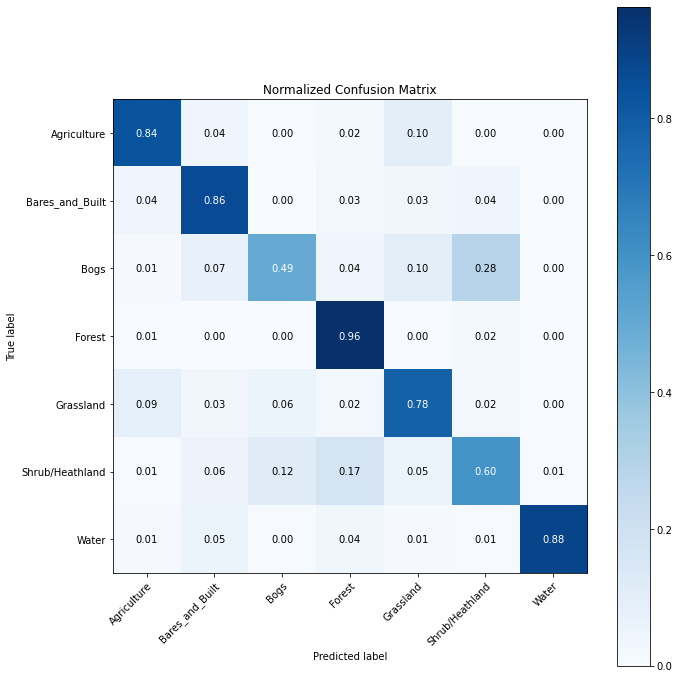

100%|██████████| 815/815 [00:14<00:00, 56.53it/s] 


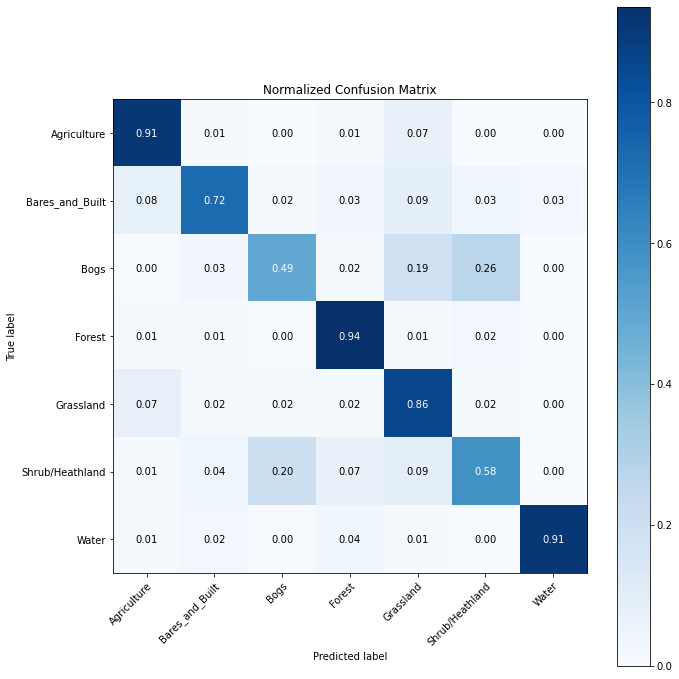

100%|██████████| 815/815 [00:19<00:00, 42.44it/s] 


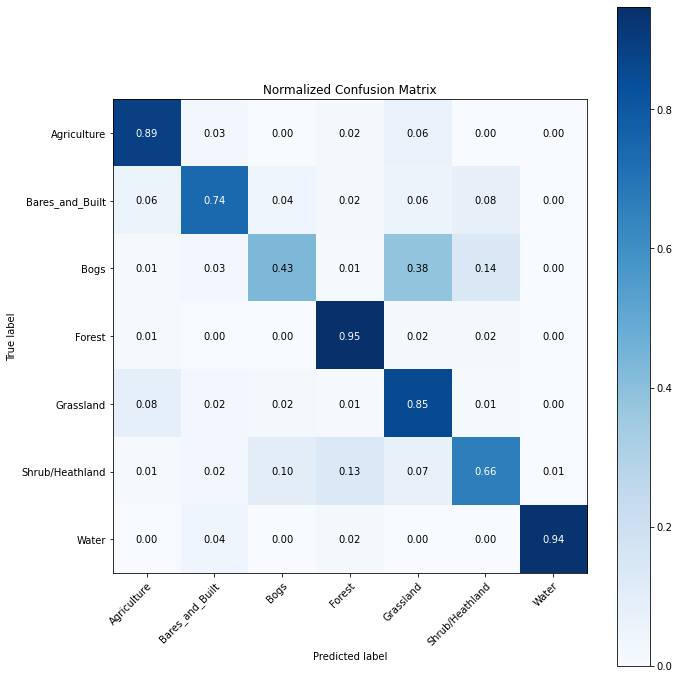

100%|██████████| 816/816 [00:10<00:00, 80.15it/s] 


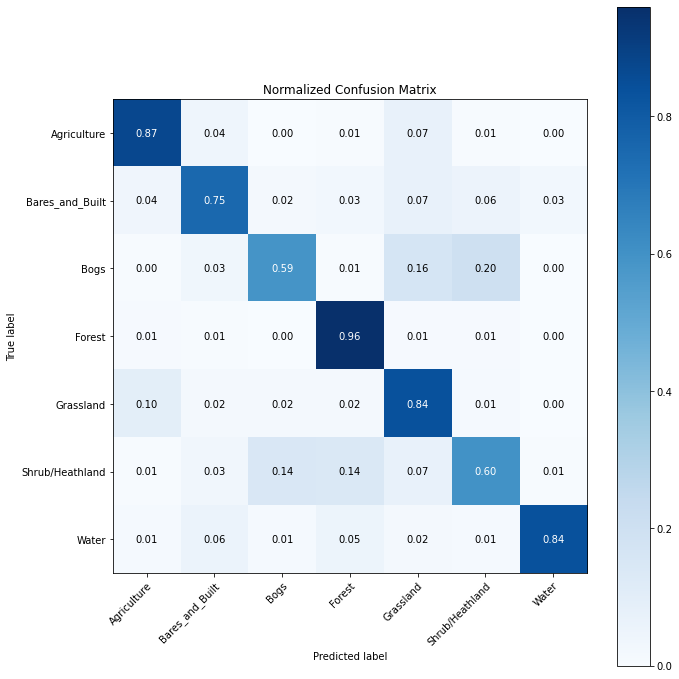

100%|██████████| 816/816 [00:13<00:00, 58.96it/s] 


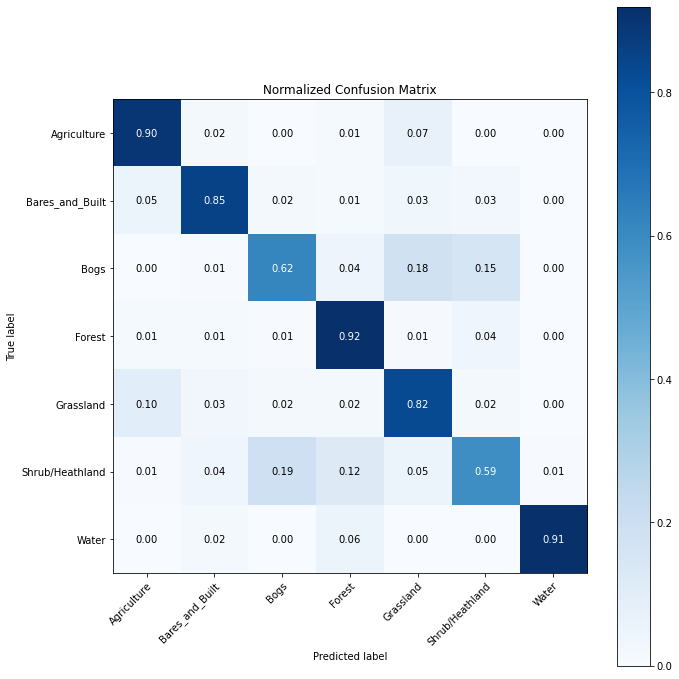

100%|██████████| 815/815 [00:15<00:00, 54.02it/s]


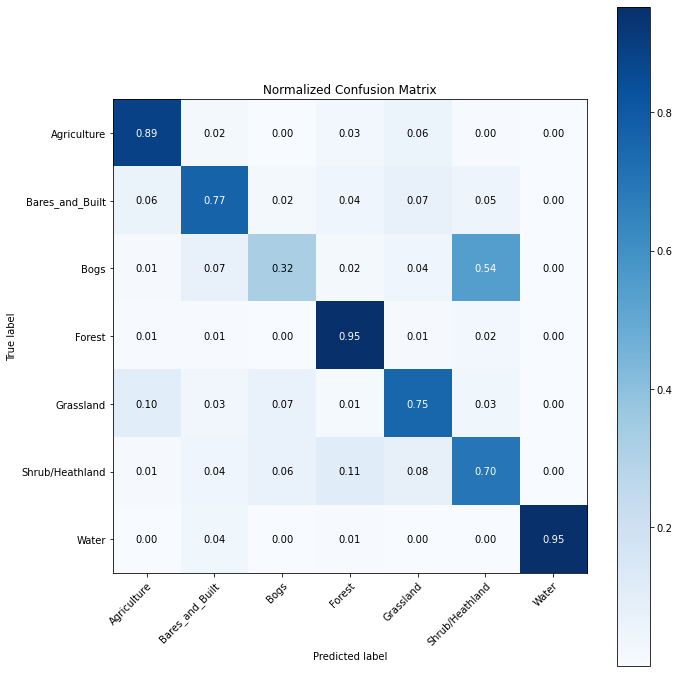

100%|██████████| 815/815 [00:35<00:00, 22.79it/s] 


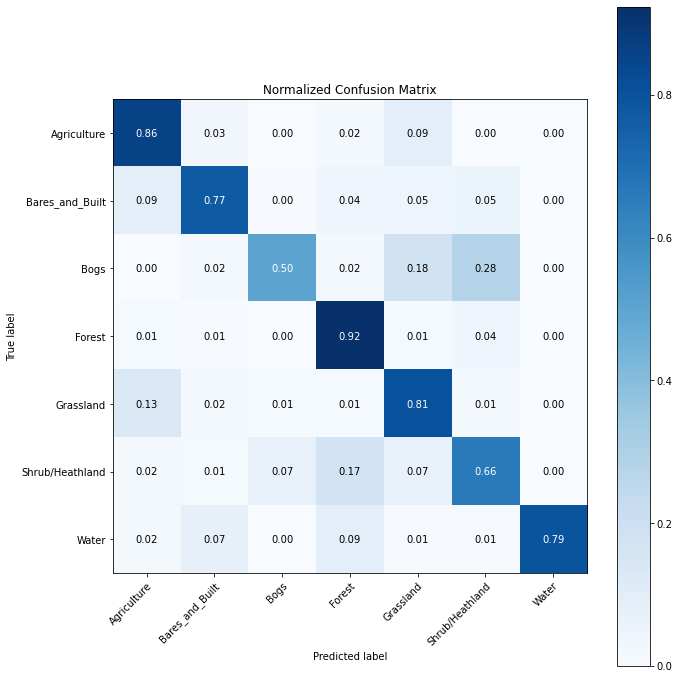

100%|██████████| 816/816 [00:21<00:00, 37.15it/s] 


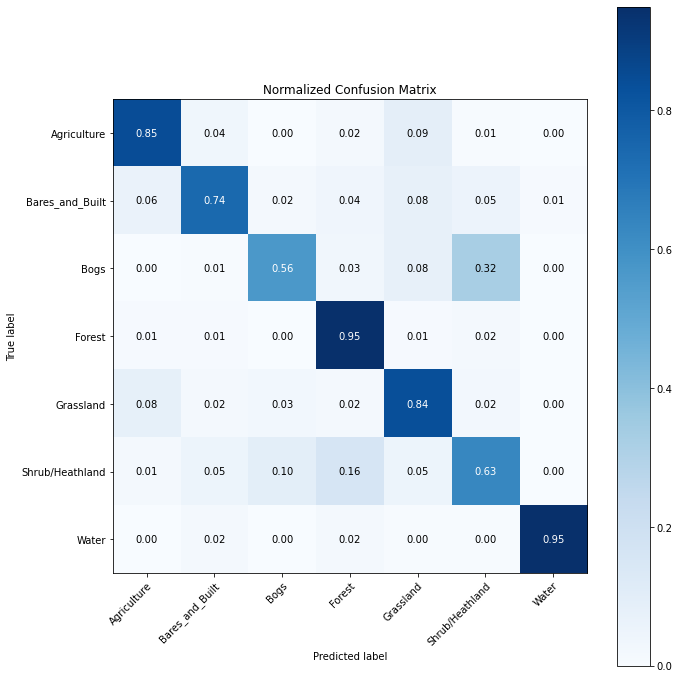

100%|██████████| 816/816 [00:13<00:00, 61.53it/s] 


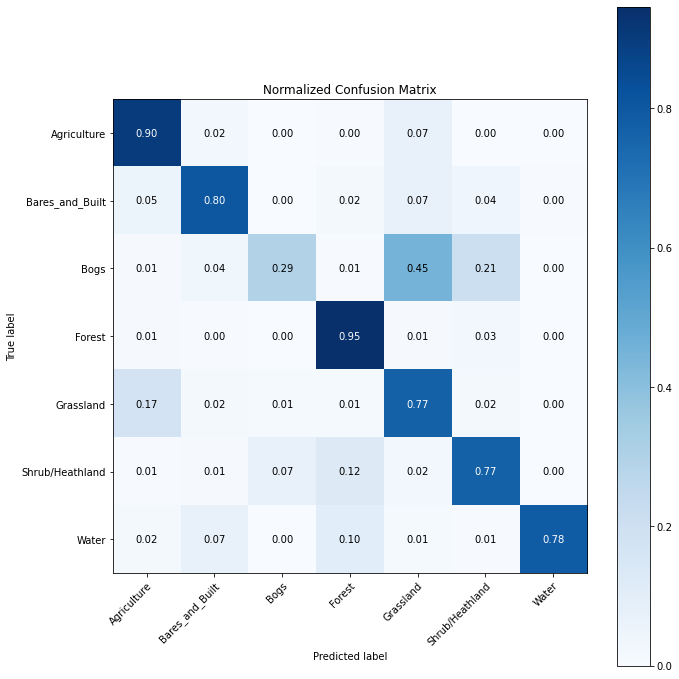

100%|██████████| 815/815 [00:19<00:00, 40.76it/s] 


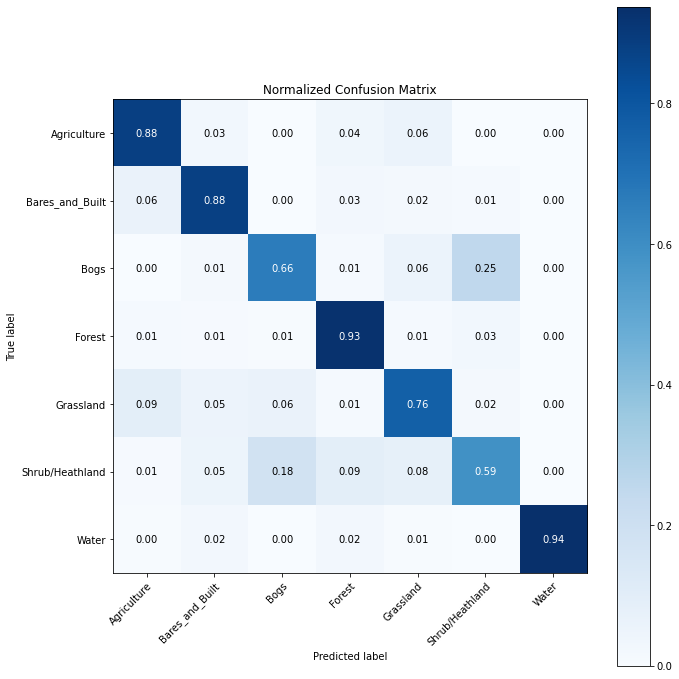

100%|██████████| 815/815 [00:13<00:00, 60.61it/s] 


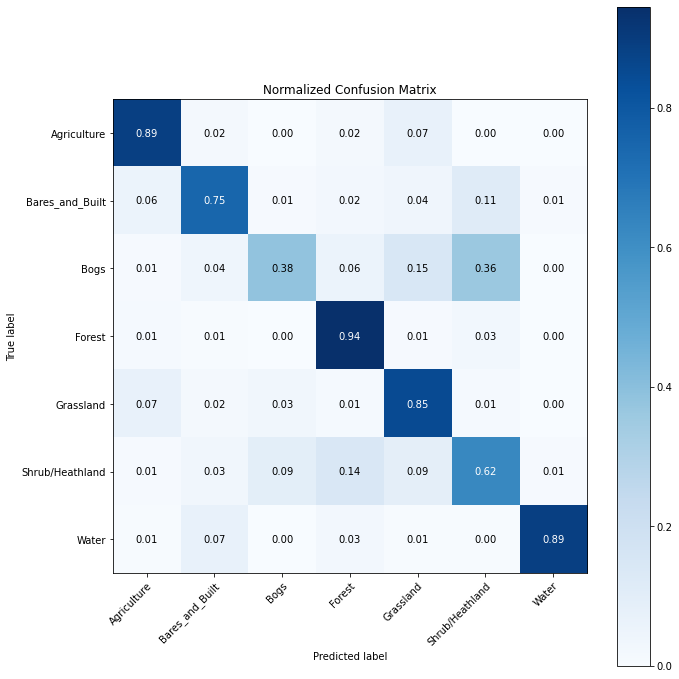

100%|██████████| 816/816 [00:09<00:00, 82.52it/s] 


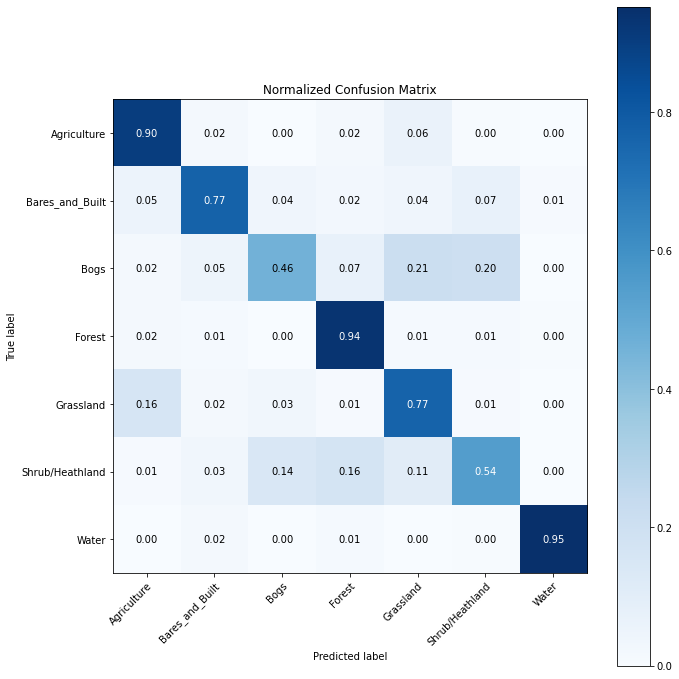

100%|██████████| 816/816 [00:15<00:00, 51.86it/s] 


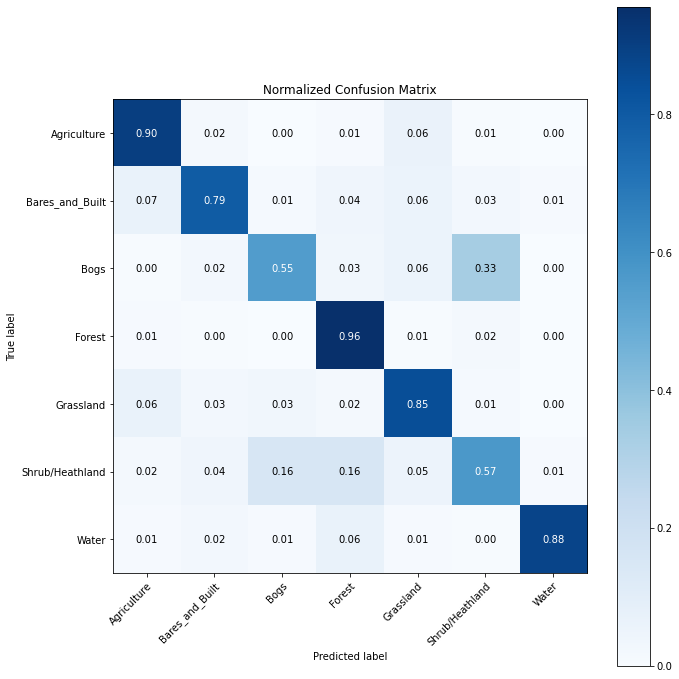

100%|██████████| 815/815 [00:09<00:00, 89.26it/s] 


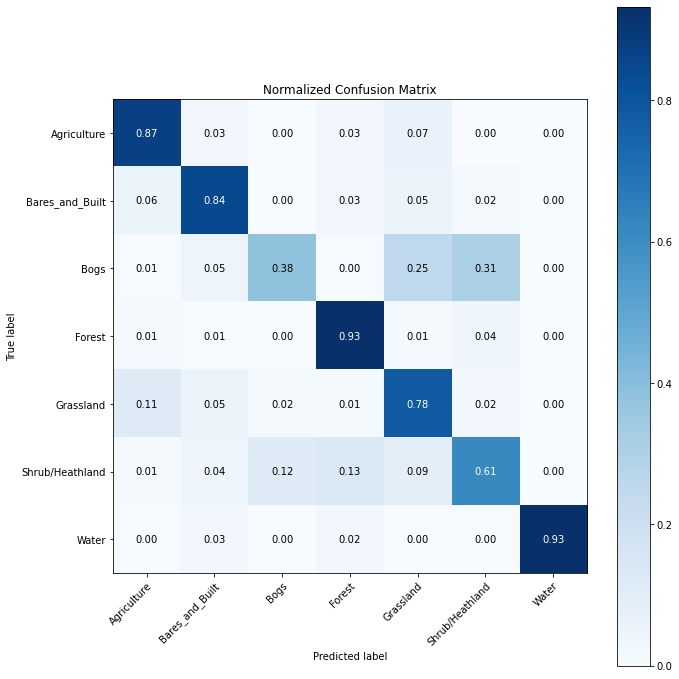

100%|██████████| 815/815 [00:08<00:00, 91.89it/s] 


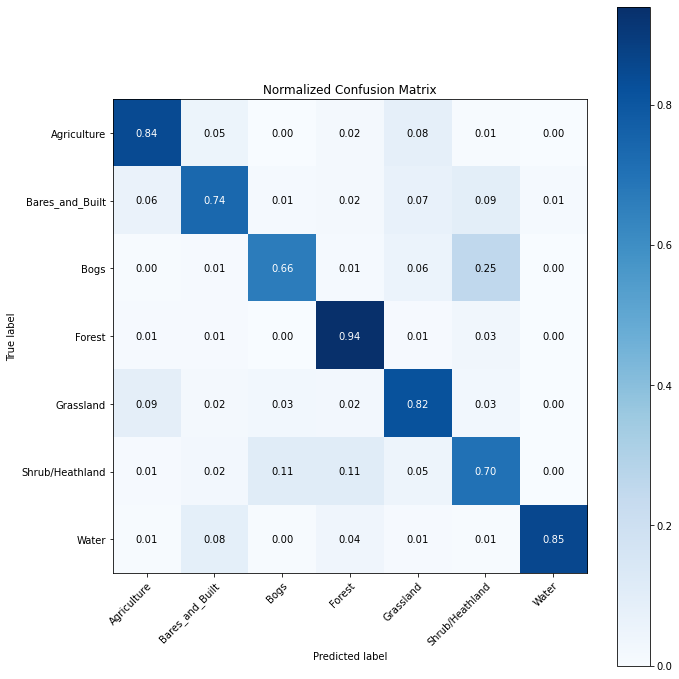

100%|██████████| 816/816 [00:09<00:00, 87.78it/s] 


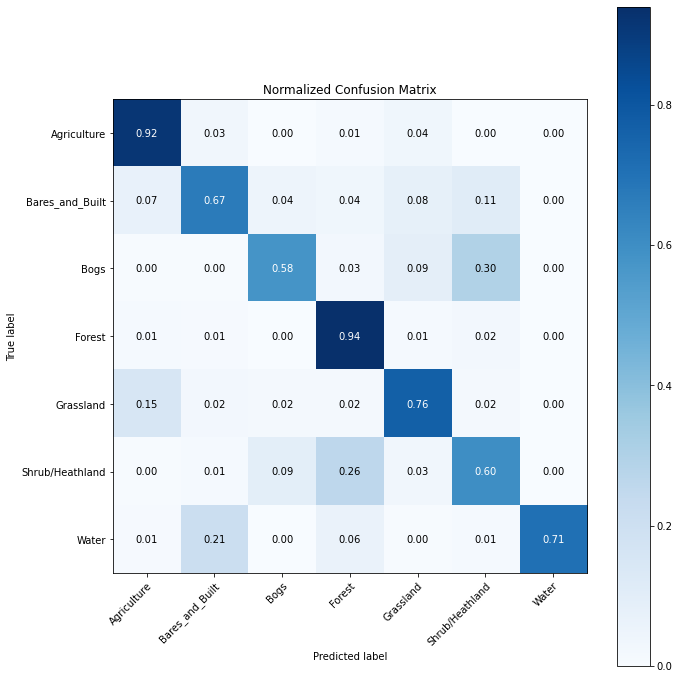

100%|██████████| 816/816 [00:10<00:00, 78.56it/s] 


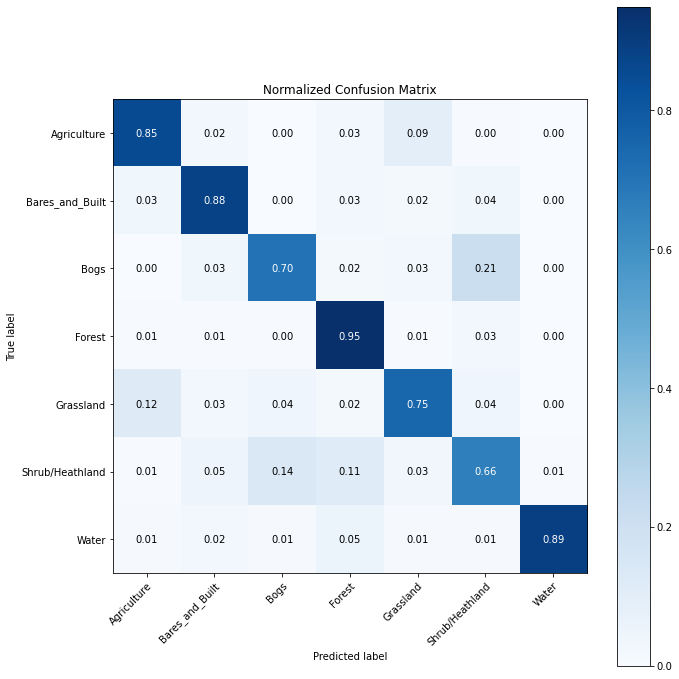

100%|██████████| 815/815 [00:08<00:00, 93.07it/s] 


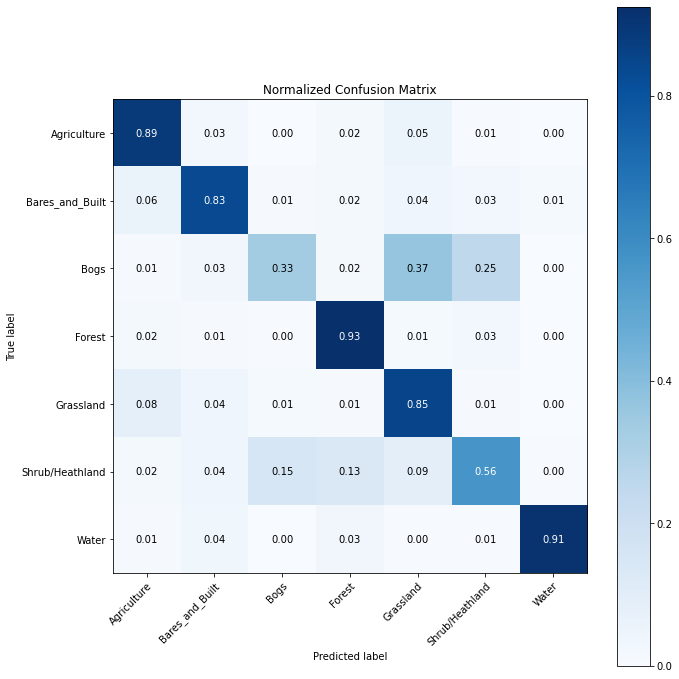

100%|██████████| 815/815 [00:09<00:00, 88.17it/s] 


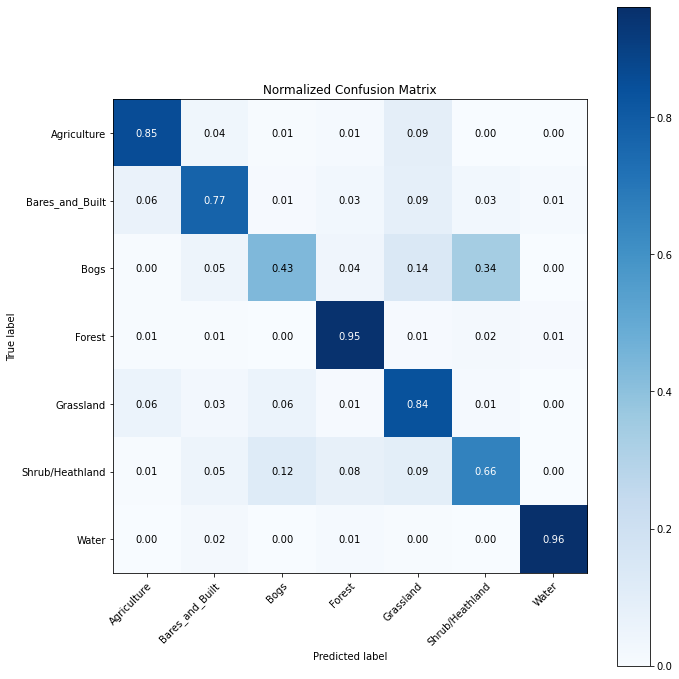

100%|██████████| 816/816 [00:32<00:00, 24.84it/s] 


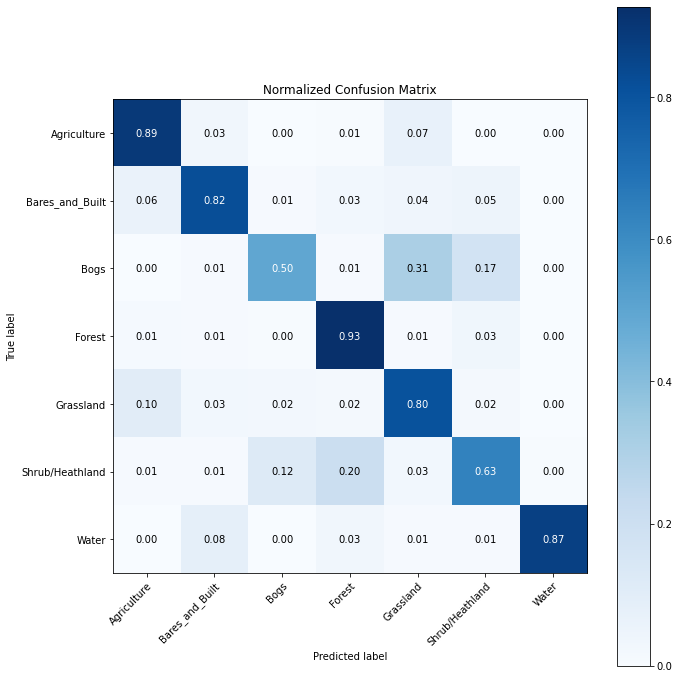

100%|██████████| 816/816 [00:09<00:00, 90.00it/s] 


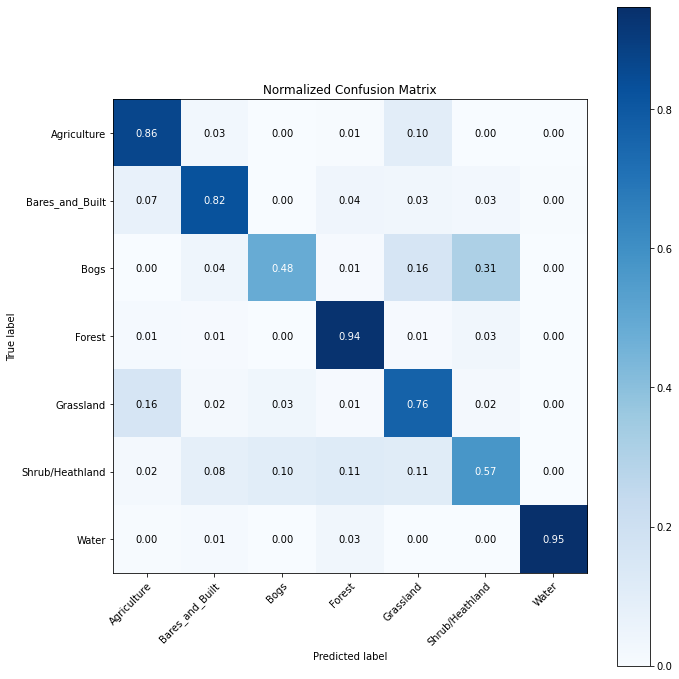

100%|██████████| 815/815 [00:10<00:00, 80.10it/s] 


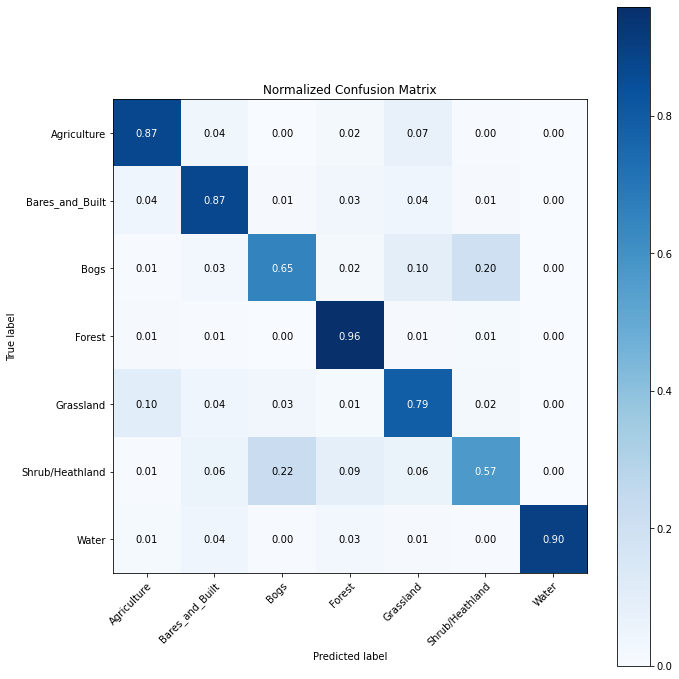

100%|██████████| 815/815 [00:10<00:00, 76.09it/s] 


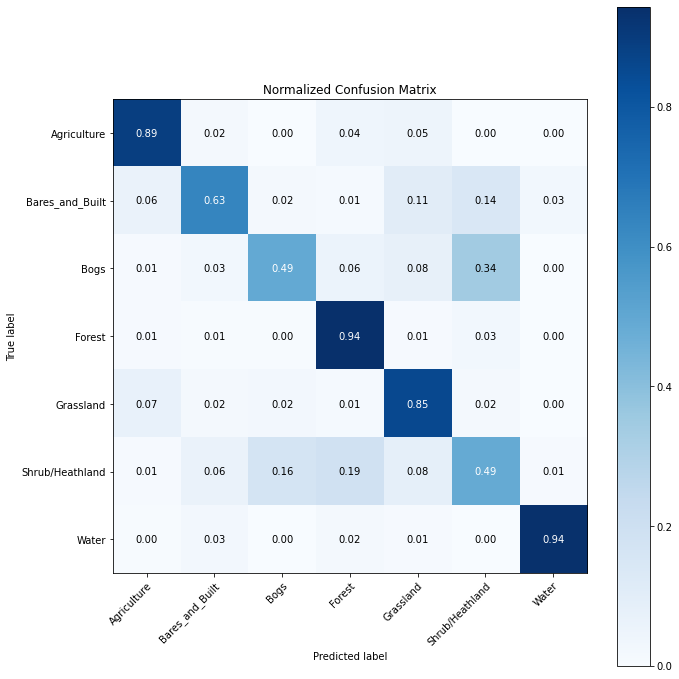

100%|██████████| 816/816 [00:14<00:00, 54.88it/s] 


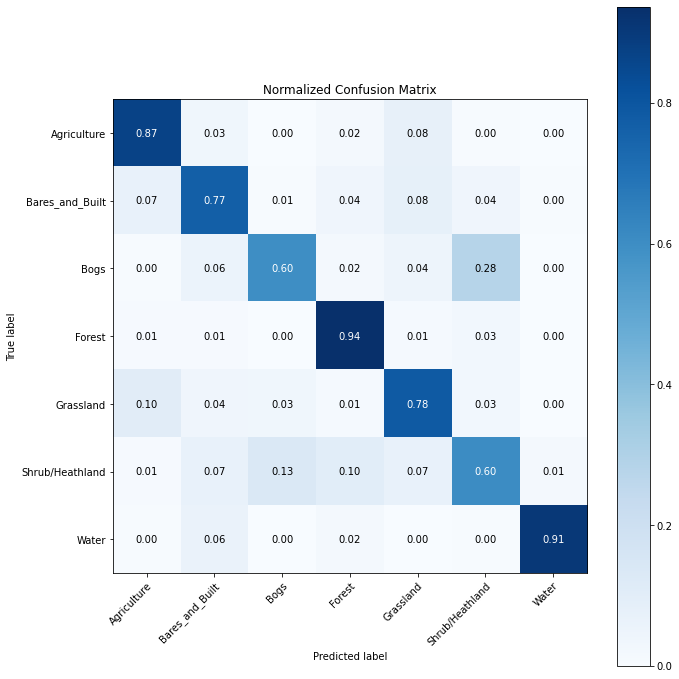

100%|██████████| 816/816 [00:10<00:00, 79.06it/s] 


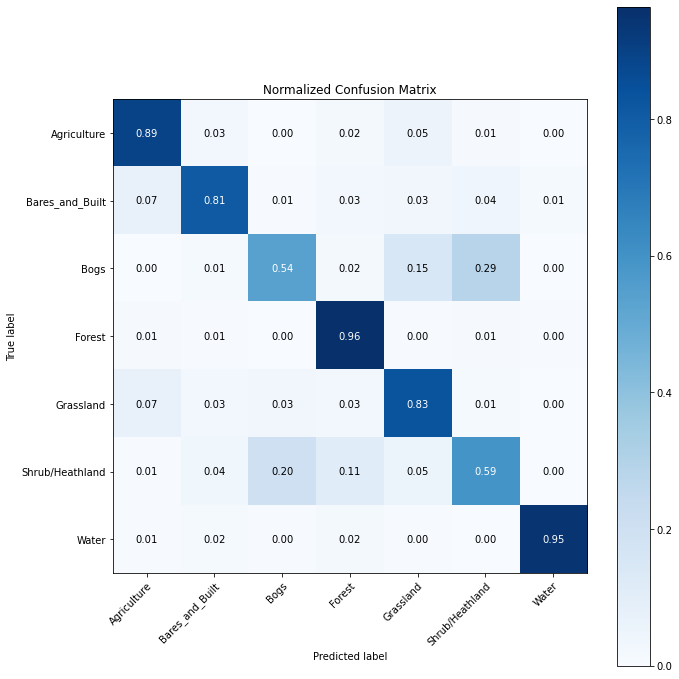

100%|██████████| 815/815 [00:11<00:00, 73.96it/s] 


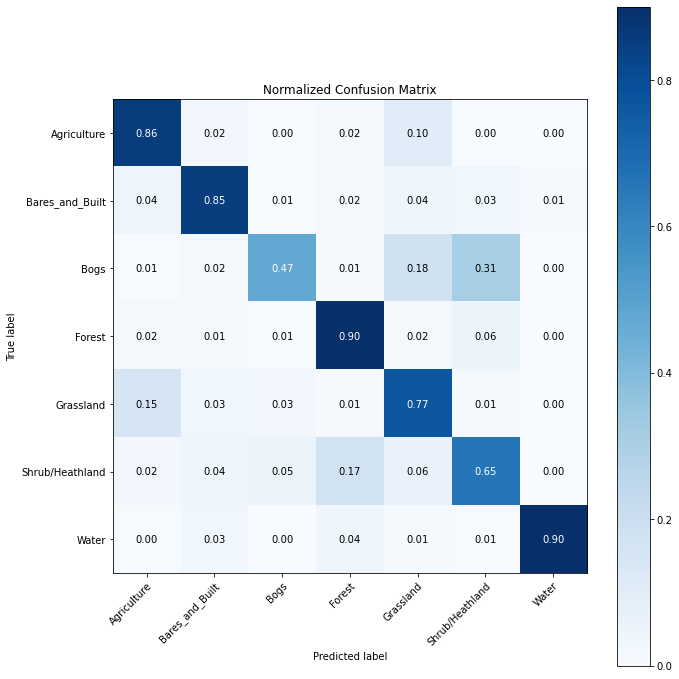

100%|██████████| 815/815 [00:16<00:00, 48.31it/s] 


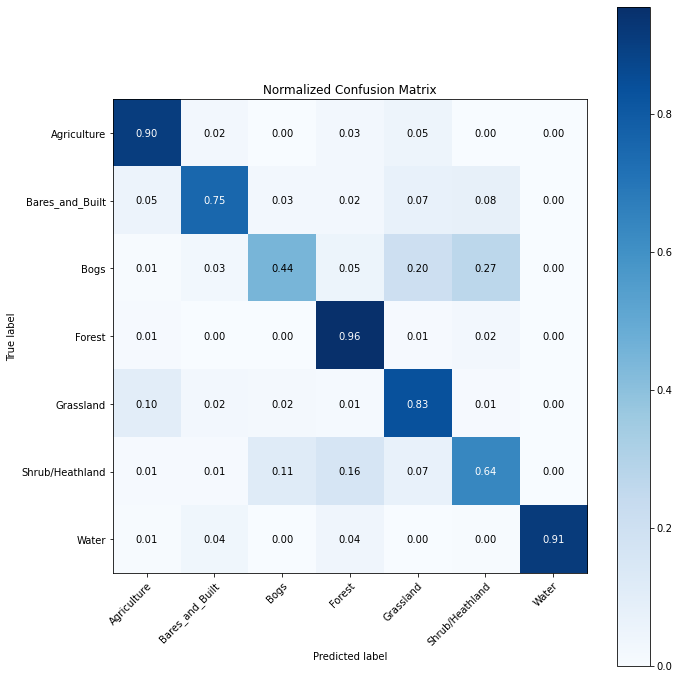

100%|██████████| 816/816 [00:10<00:00, 74.68it/s] 


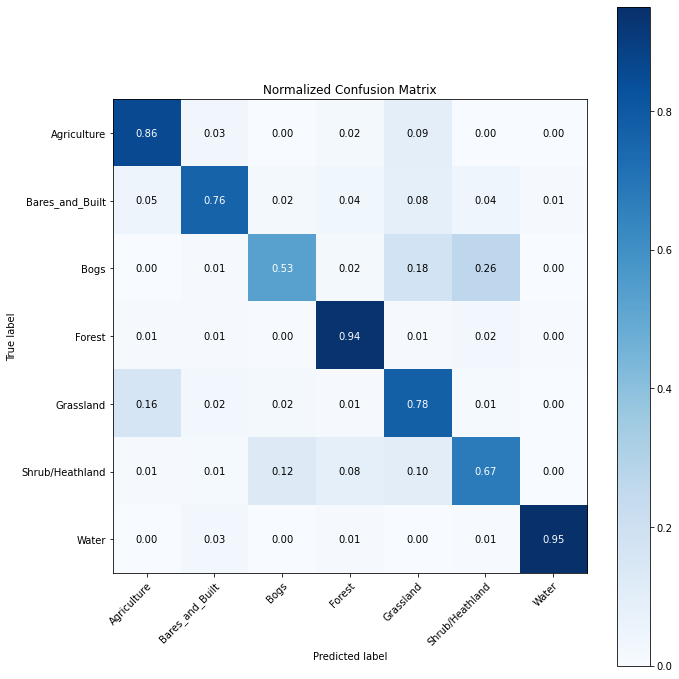

100%|██████████| 816/816 [00:11<00:00, 73.12it/s] 


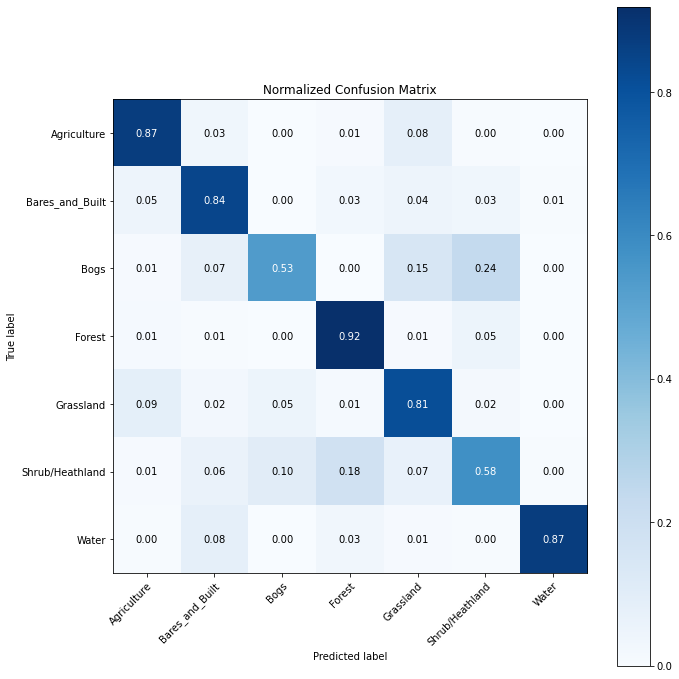

100%|██████████| 815/815 [03:19<00:00,  4.08it/s] 


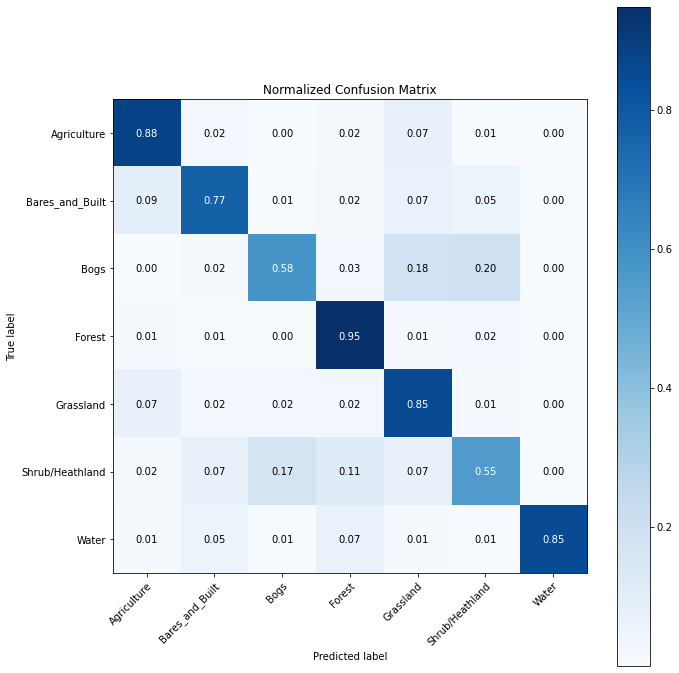

100%|██████████| 815/815 [00:13<00:00, 58.54it/s] 


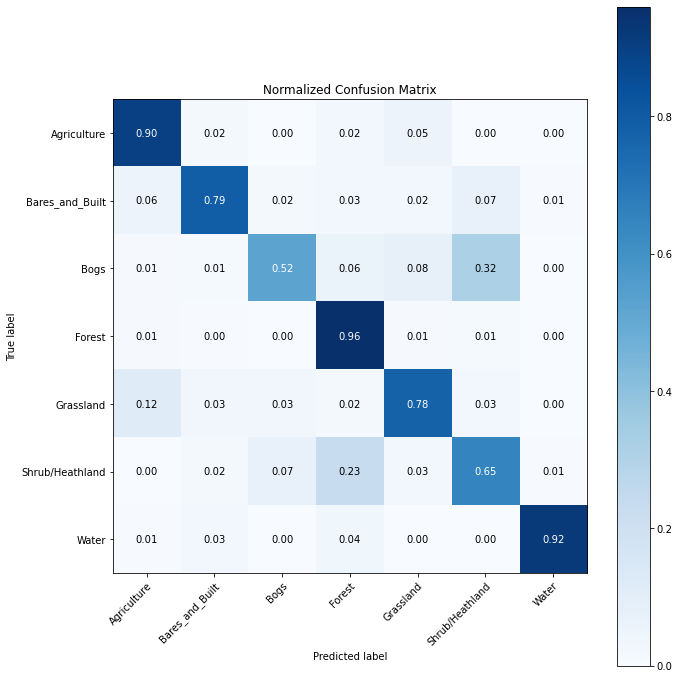

The mean accuracy is:0.8433256408333726
The mean balanced accuracy is:0.7745083558669652
The mean precision is:0.8454959718556324
The mean recall is:0.8433256408333726
The mean f1 score is:0.842999611714834
FINAL MEAN CONFUSION MATRIX


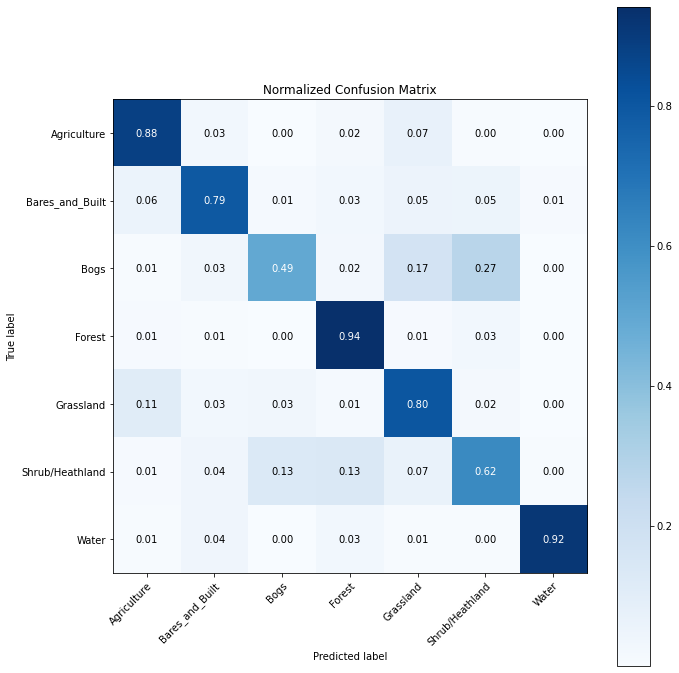

In [88]:
loops=10
for i in range(loops):
    
    results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm = rf_cross_validate_ml(training_vectors,raster_path,class_dict,seed=i,folds=4)
    mean_accuracy.append(results_acc)
    mean_balanced_accuracy.append(results_bal_acc)
    mean_recall.append(results_recall)
    mean_prec.append(results_prec)
    mean_f1.append(results_f1)
    mean_cm.append(results_cm)

print(f'The mean accuracy is:{np.array(mean_accuracy).mean()}')
print(f'The mean balanced accuracy is:{np.array(mean_balanced_accuracy).mean()}')
print(f'The mean precision is:{np.array(mean_prec).mean()}')
print(f'The mean recall is:{np.array(mean_recall).mean()}')
print(f'The mean f1 score is:{np.array(mean_f1).mean()}')

# the final confusion matrix
final_sum_cm = np.zeros(mean_cm[0].shape)
for matrix in mean_cm:
   final_sum_cm +=matrix
final_mean_cm = final_sum_cm/loops

print('FINAL MEAN CONFUSION MATRIX')
plot_cm(final_mean_cm,classes)

In [89]:
mean_balanced_accuracy_df = pd.DataFrame(mean_balanced_accuracy,columns=['mean_balanced_accuracy'])
mean_balanced_accuracy_df.describe()

mean_balanced_accuracy
count               10.000000
mean                 0.774508
std                  0.004194
min                  0.768336
25%                  0.772240
50%                  0.774461
75%                  0.776300
max                  0.781307

In [91]:
import seaborn as sns

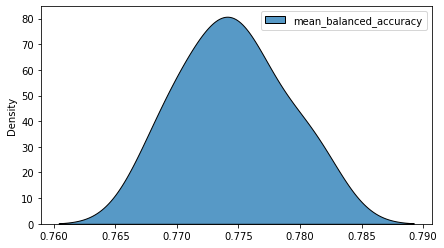

In [92]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=mean_balanced_accuracy_df, multiple="stack")
plt.show()

**XGBoost Model**

In [93]:
mean_accuracy = []
mean_balanced_accuracy = []
mean_recall = []
mean_prec = []
mean_f1 = []
mean_cm = []

100%|██████████| 816/816 [00:26<00:00, 31.25it/s]


[12:33:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




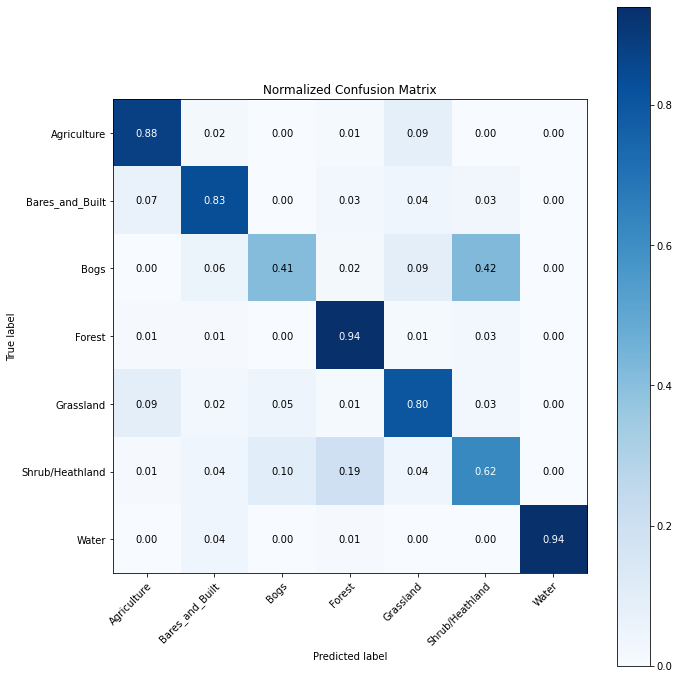

100%|██████████| 816/816 [00:13<00:00, 60.83it/s] 


[12:35:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




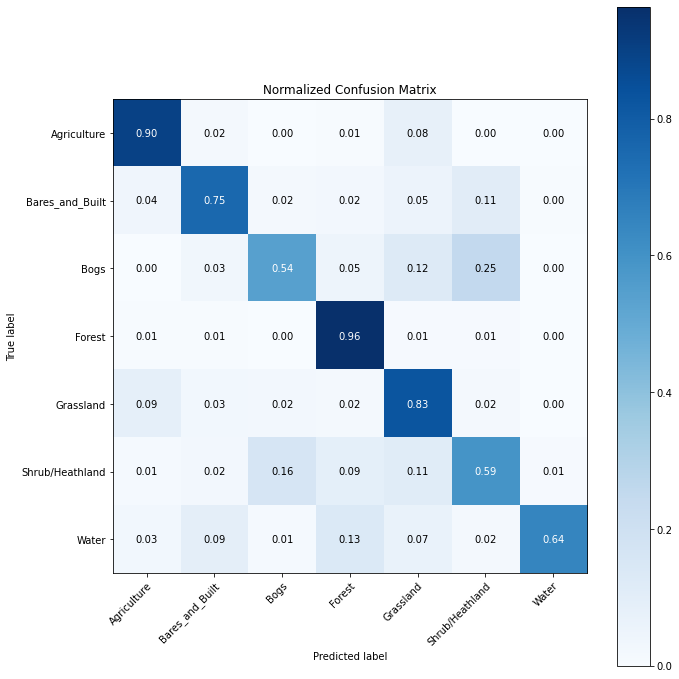

100%|██████████| 815/815 [00:11<00:00, 68.61it/s] 


[12:37:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




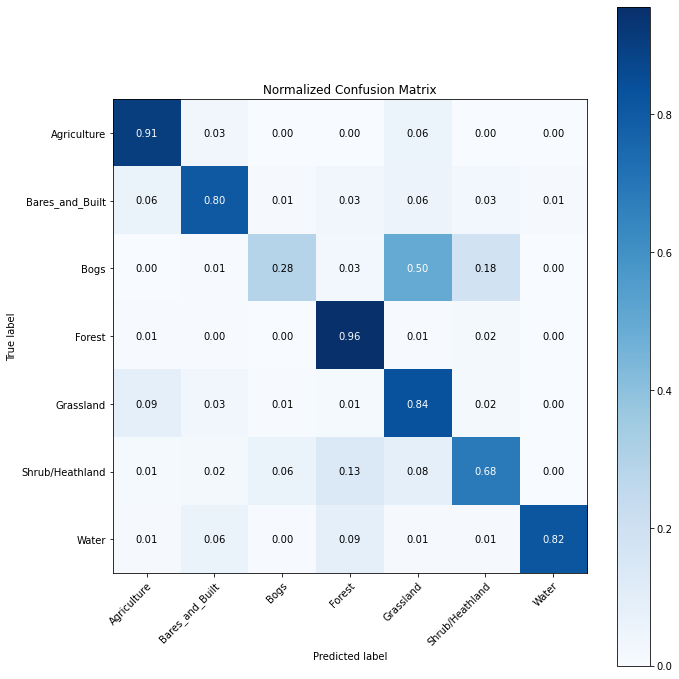

100%|██████████| 815/815 [00:14<00:00, 56.68it/s] 


[12:39:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




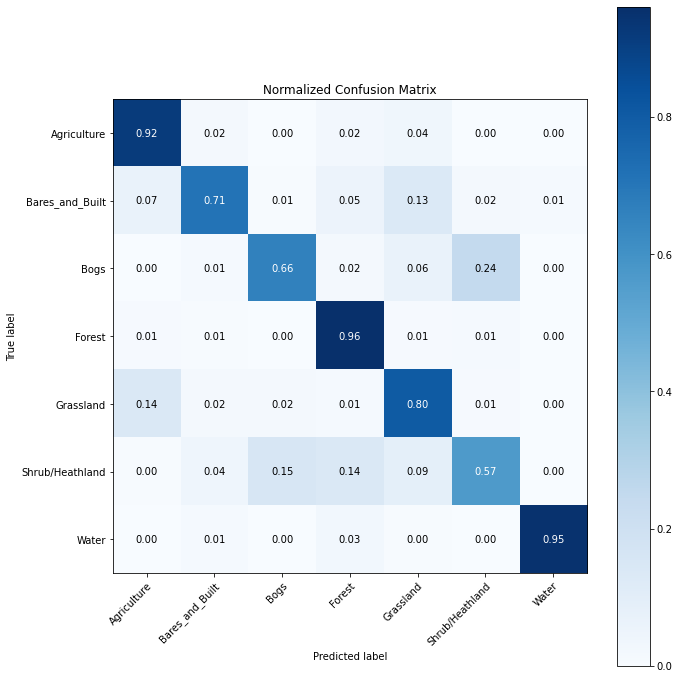

100%|██████████| 816/816 [00:35<00:00, 22.67it/s]


[12:42:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




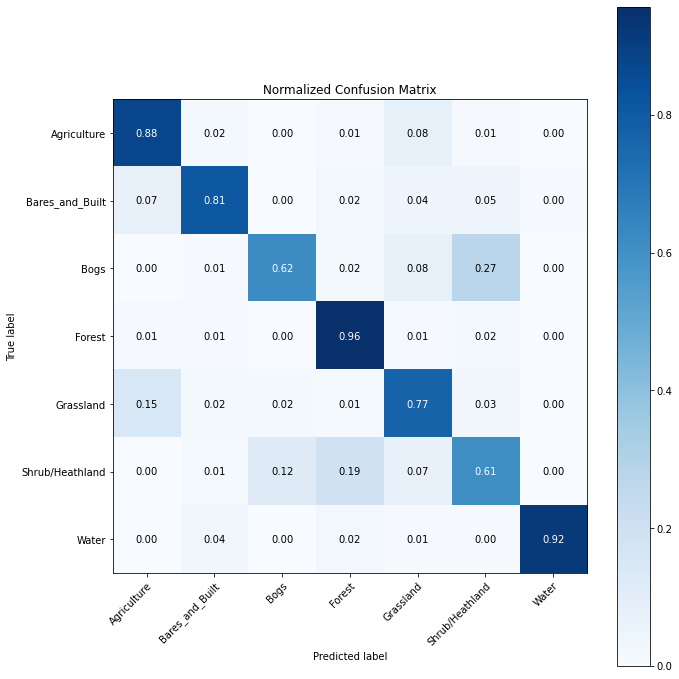

100%|██████████| 816/816 [00:18<00:00, 44.51it/s] 


[12:44:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




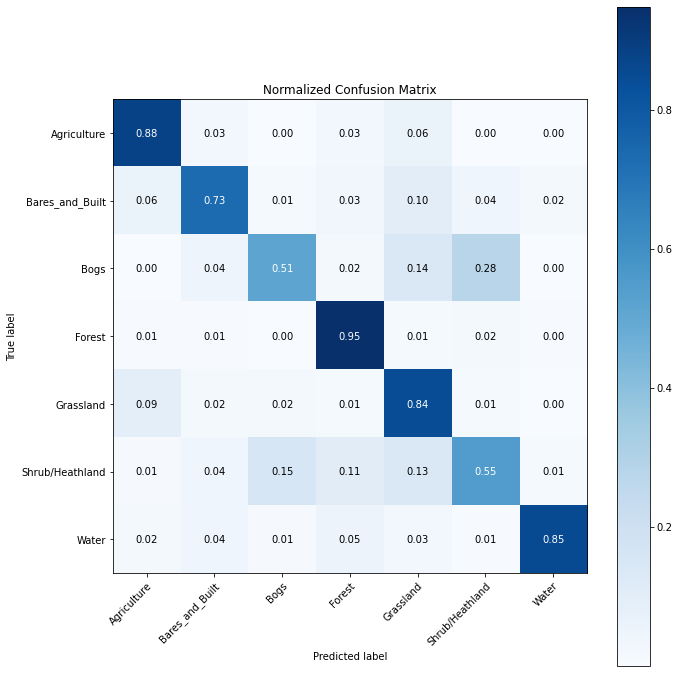

100%|██████████| 815/815 [00:21<00:00, 38.10it/s]


[12:47:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




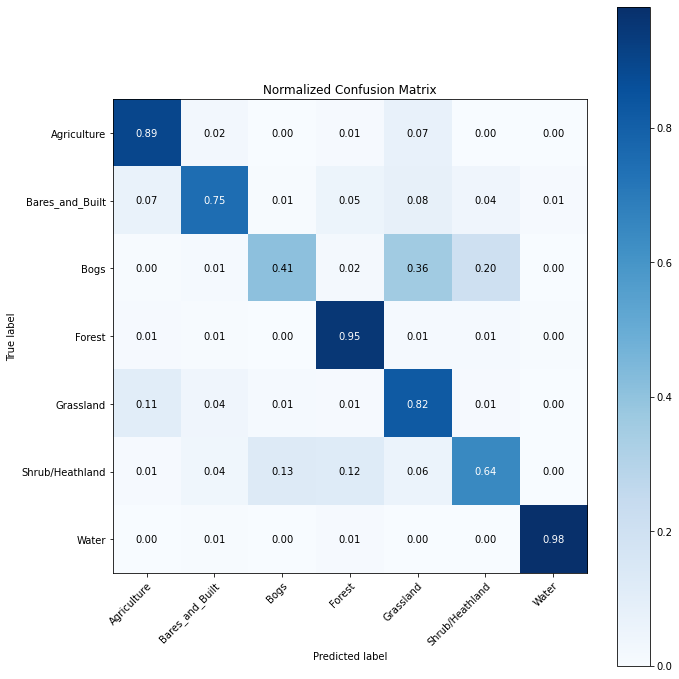

100%|██████████| 815/815 [00:13<00:00, 61.66it/s] 


[12:50:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




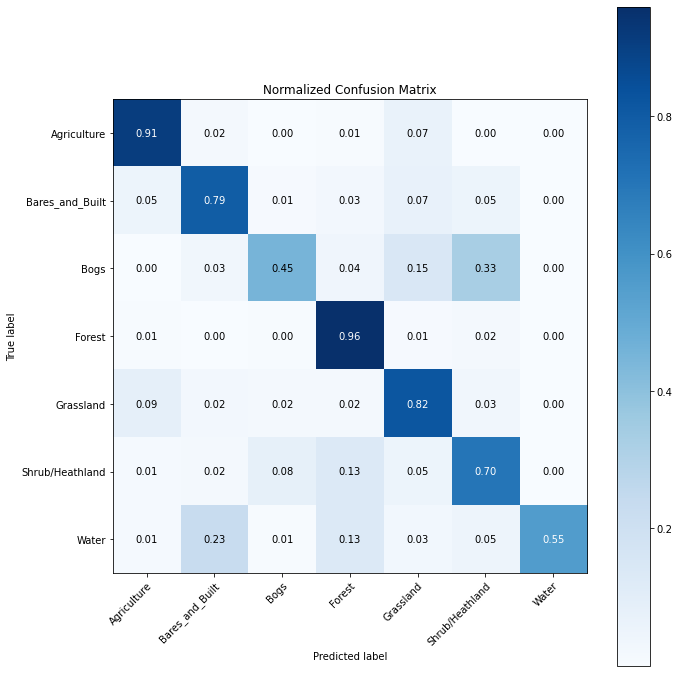

100%|██████████| 816/816 [00:29<00:00, 27.98it/s]


[12:53:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




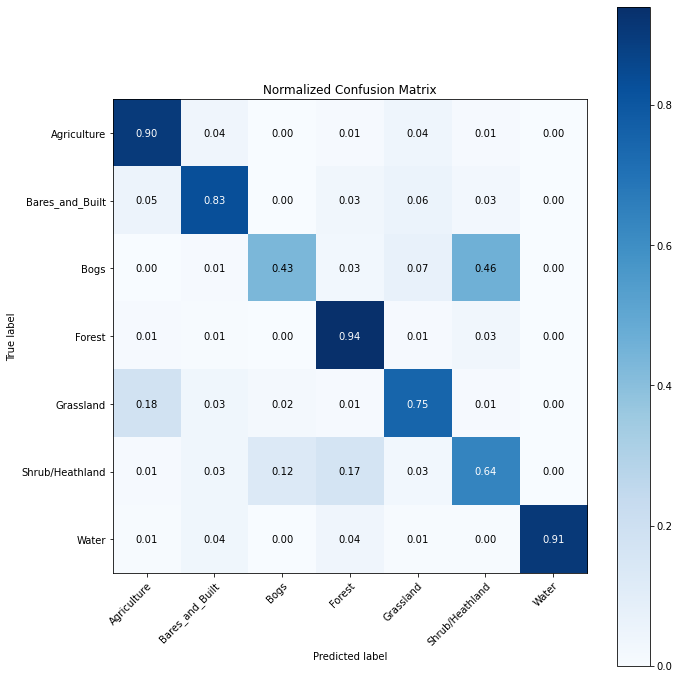

100%|██████████| 816/816 [00:20<00:00, 39.27it/s] 


[12:56:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




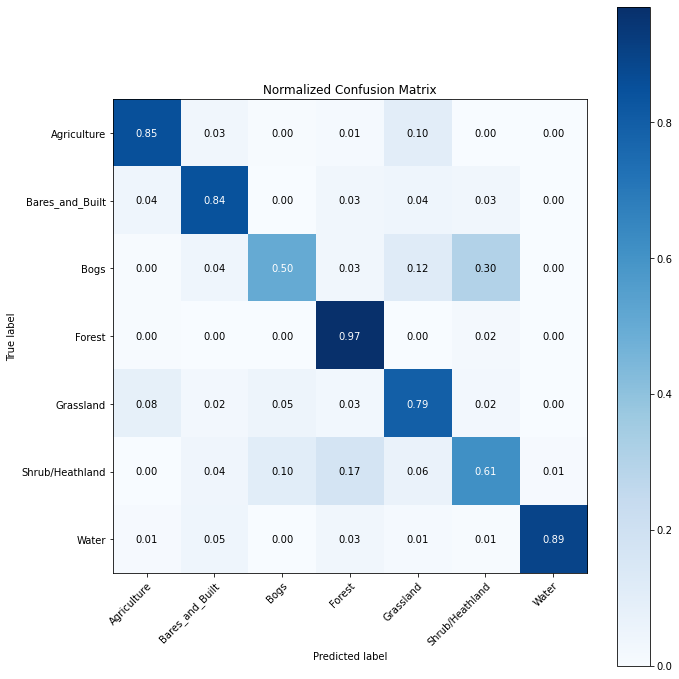

100%|██████████| 815/815 [00:21<00:00, 38.61it/s] 


[12:59:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




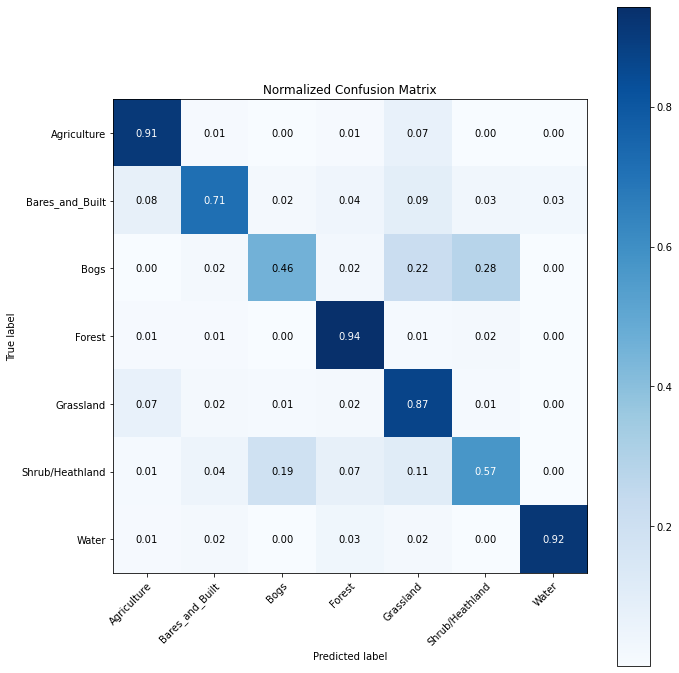

100%|██████████| 815/815 [00:31<00:00, 26.26it/s] 


[13:03:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




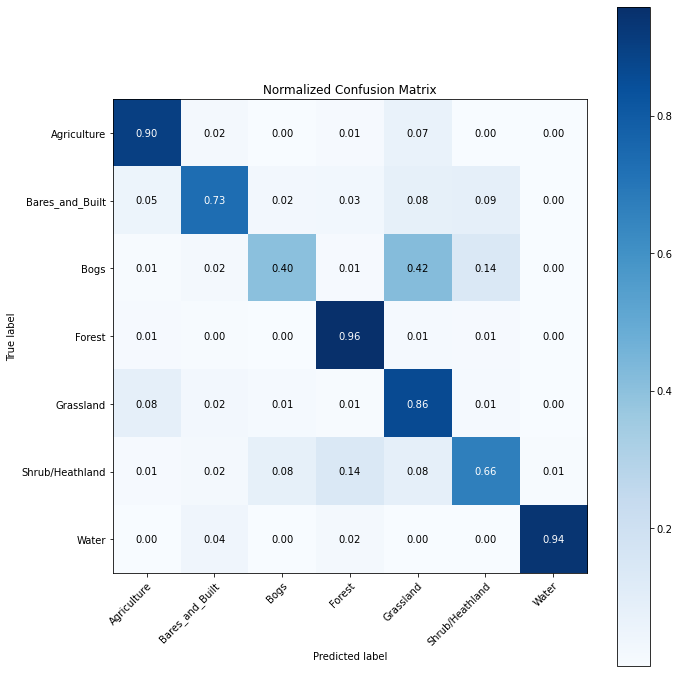

100%|██████████| 816/816 [00:13<00:00, 58.99it/s] 


[13:05:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




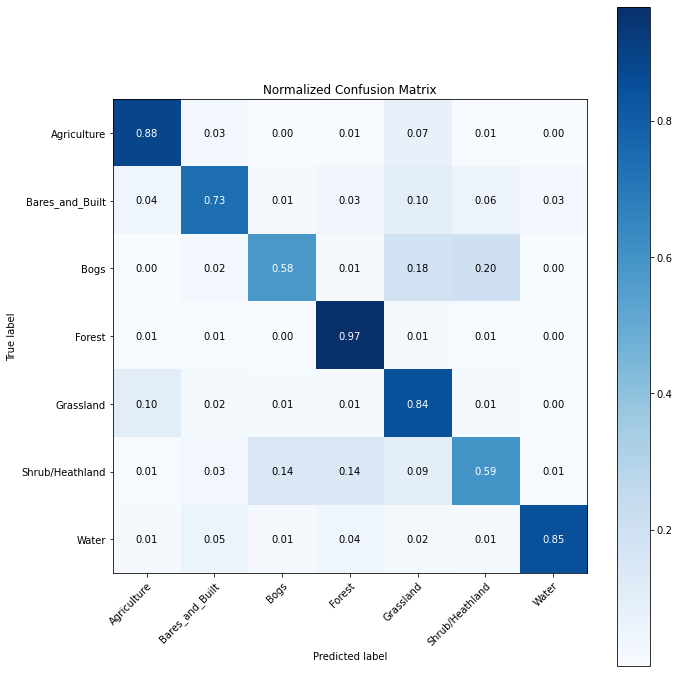

100%|██████████| 816/816 [00:09<00:00, 86.08it/s] 


[13:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




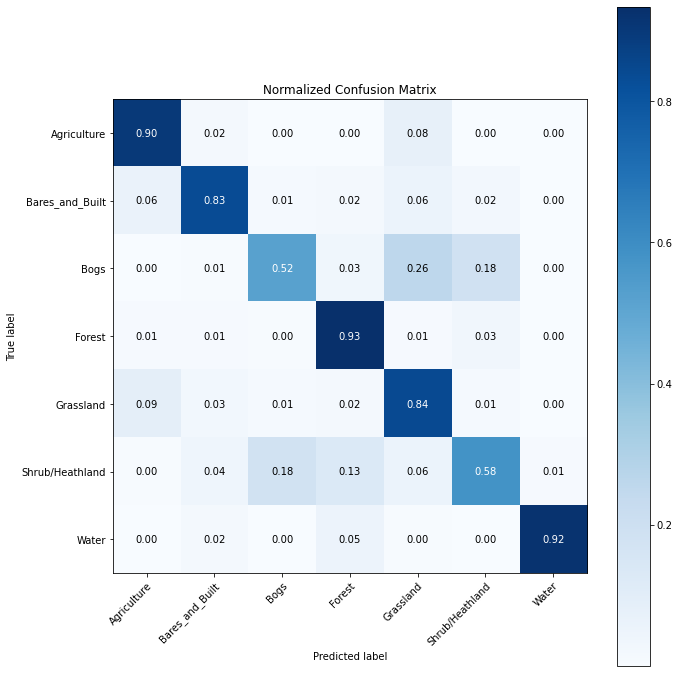

100%|██████████| 815/815 [00:10<00:00, 74.51it/s] 


[13:10:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




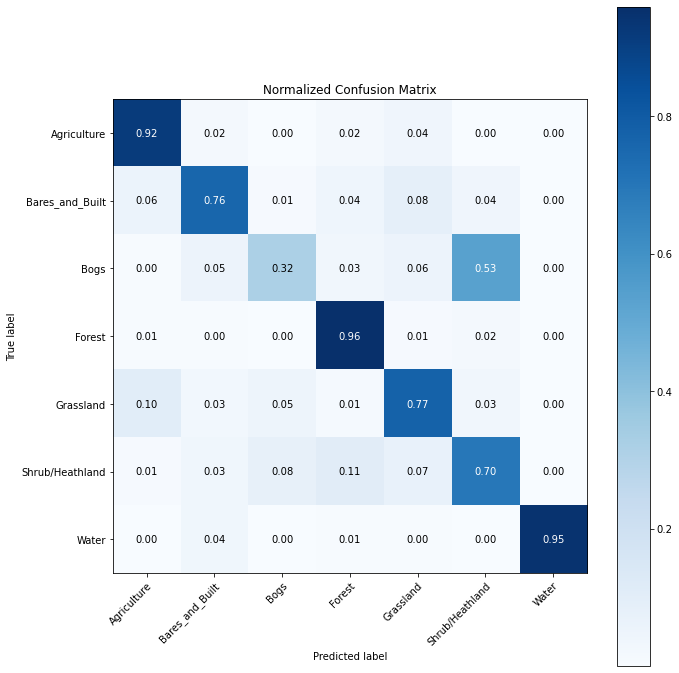

100%|██████████| 815/815 [00:16<00:00, 48.31it/s] 


[13:12:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




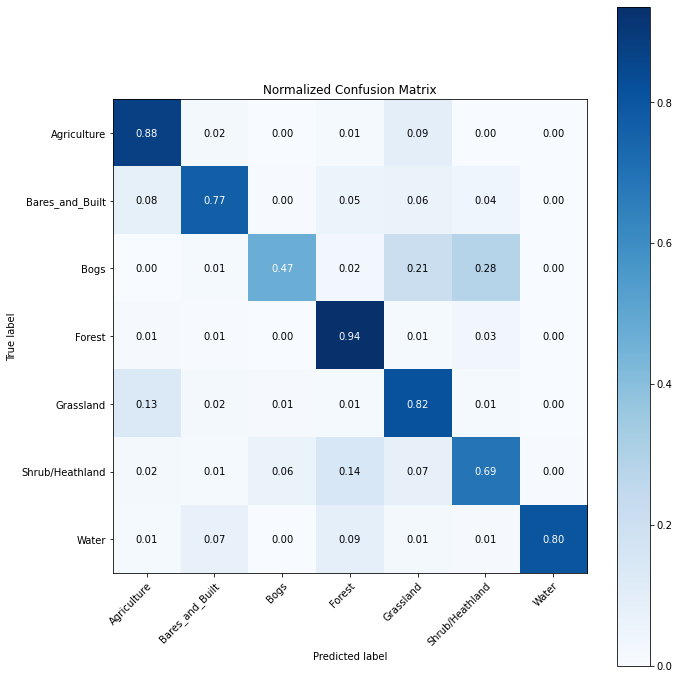

100%|██████████| 816/816 [00:15<00:00, 53.73it/s] 


[13:15:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




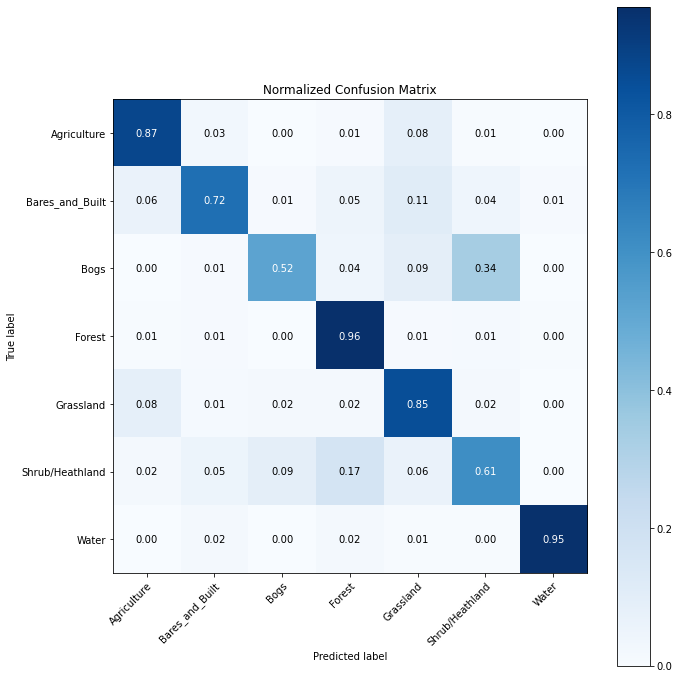

100%|██████████| 816/816 [00:19<00:00, 42.45it/s] 


[13:19:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




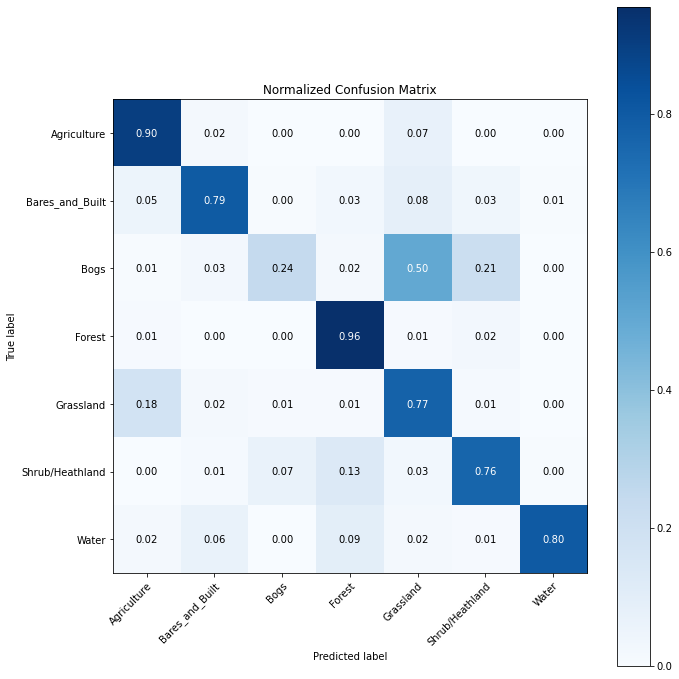

100%|██████████| 815/815 [00:33<00:00, 24.57it/s]


[13:22:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




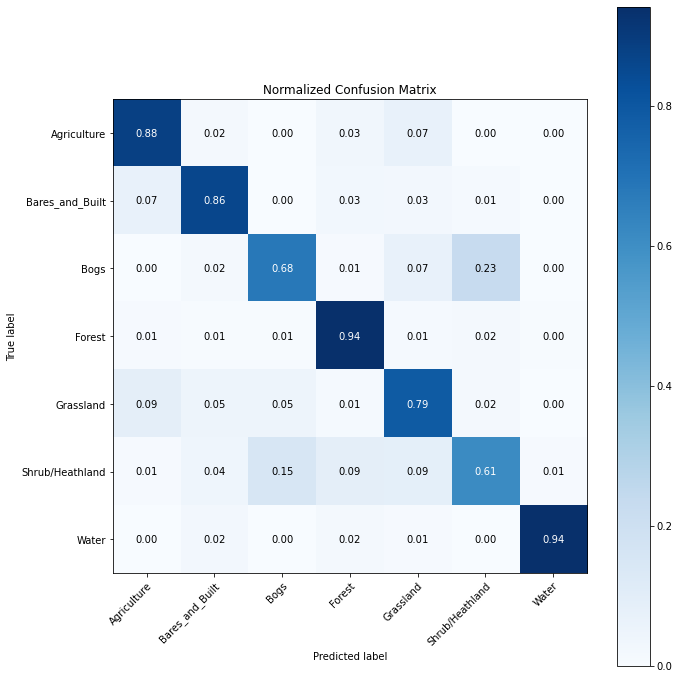

100%|██████████| 815/815 [00:13<00:00, 58.84it/s] 


[13:24:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




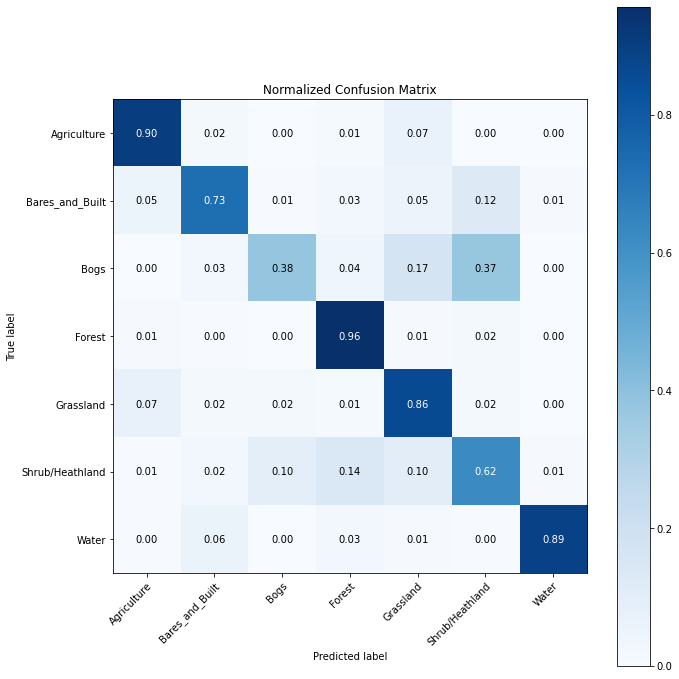

100%|██████████| 816/816 [00:17<00:00, 46.28it/s]


[13:27:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




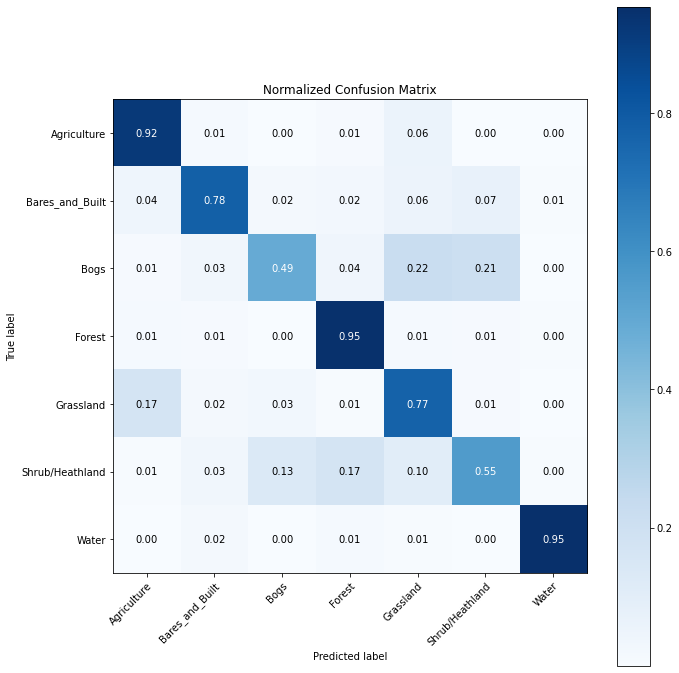

100%|██████████| 816/816 [00:10<00:00, 80.91it/s] 


[13:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




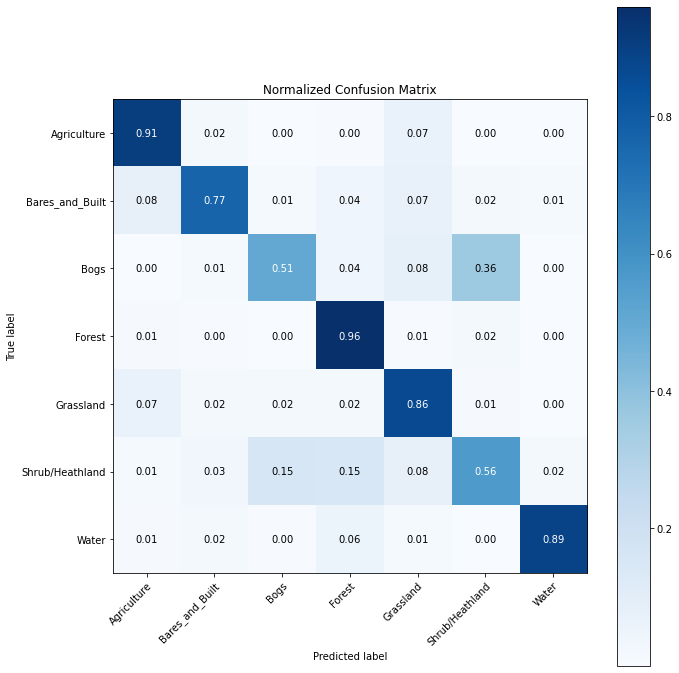

100%|██████████| 815/815 [00:18<00:00, 44.01it/s] 


[13:33:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




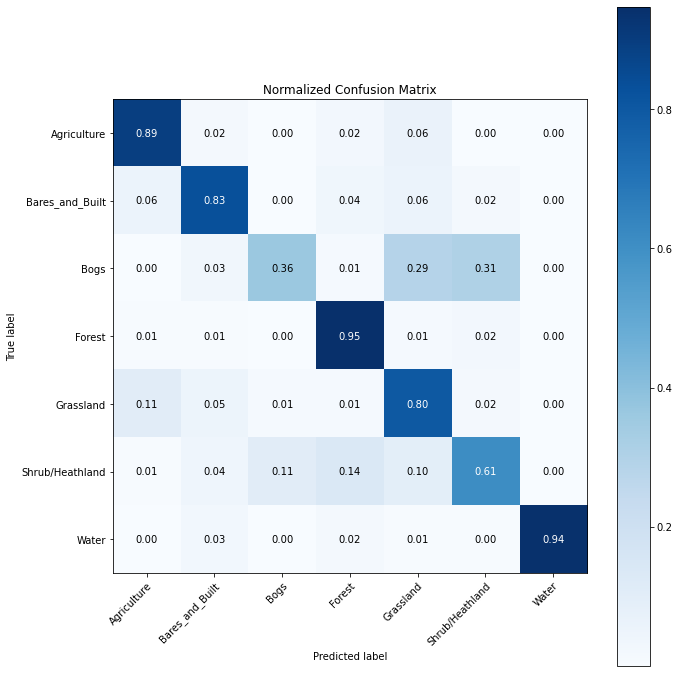

100%|██████████| 815/815 [00:09<00:00, 85.42it/s] 


[13:35:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




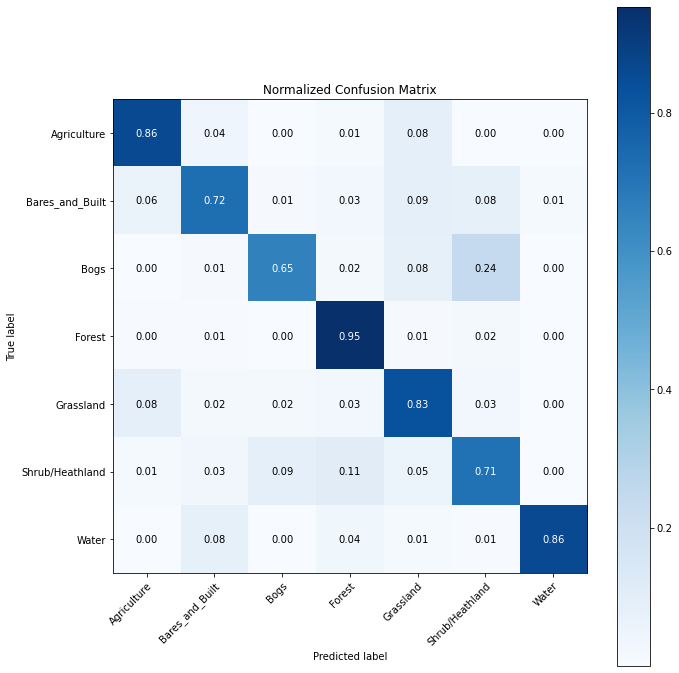

100%|██████████| 816/816 [00:11<00:00, 68.27it/s] 


[13:37:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




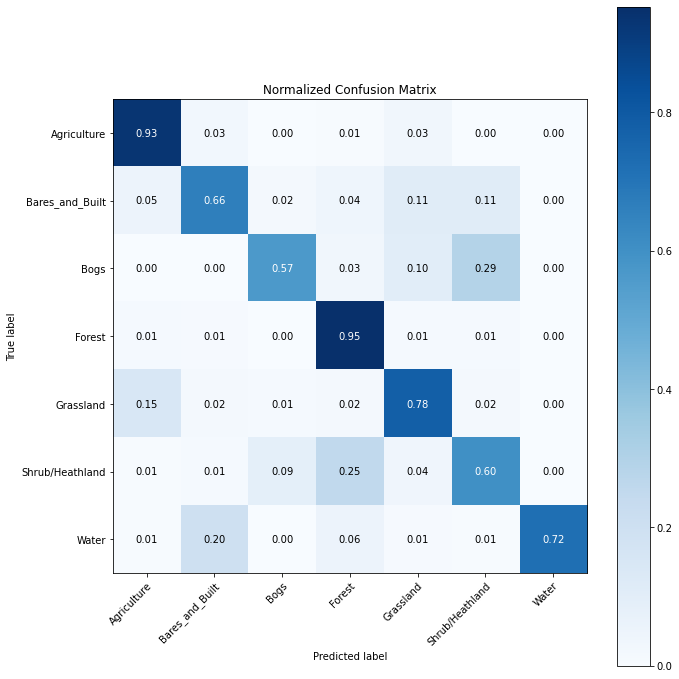

100%|██████████| 816/816 [00:16<00:00, 50.78it/s] 


[13:40:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




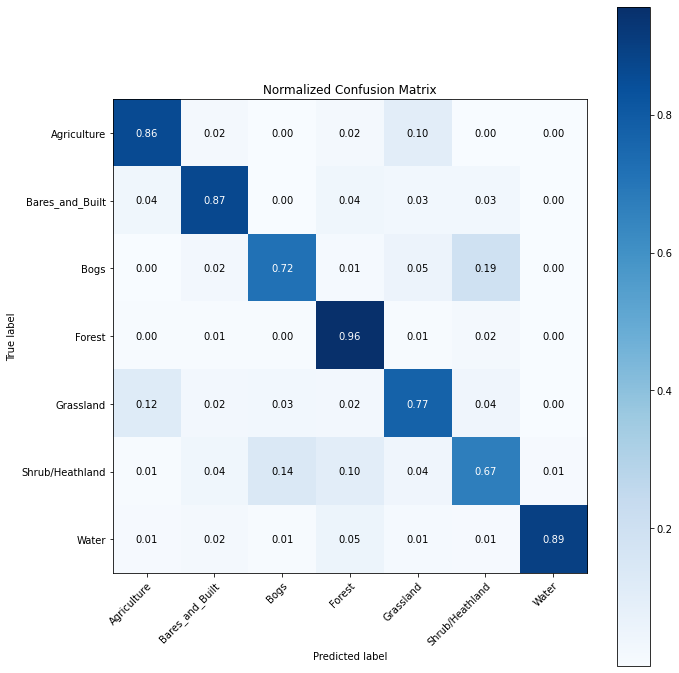

100%|██████████| 815/815 [00:48<00:00, 16.81it/s] 


[13:44:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




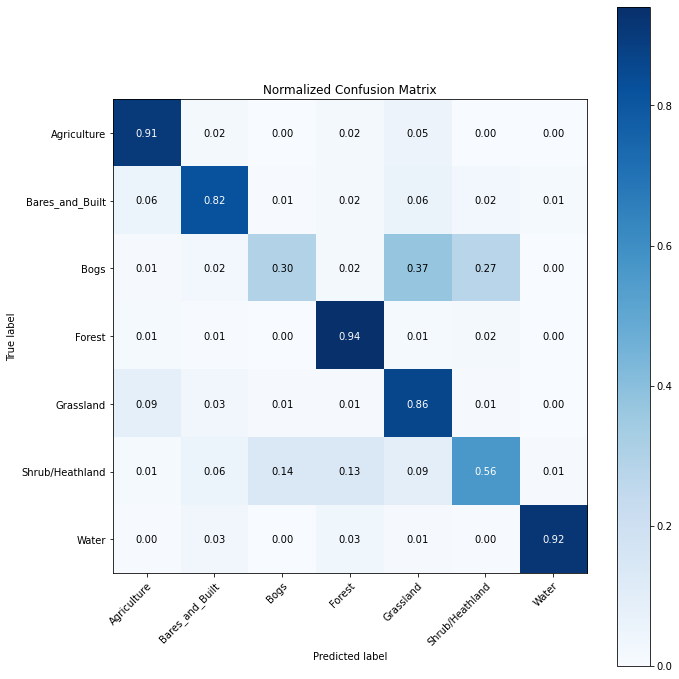

100%|██████████| 815/815 [00:12<00:00, 65.38it/s] 


[13:47:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




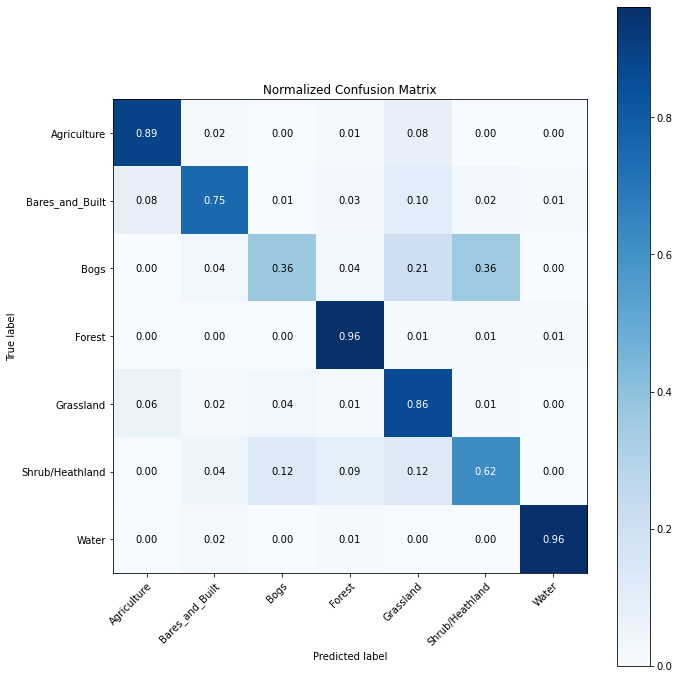

100%|██████████| 816/816 [00:29<00:00, 27.28it/s]


[13:51:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




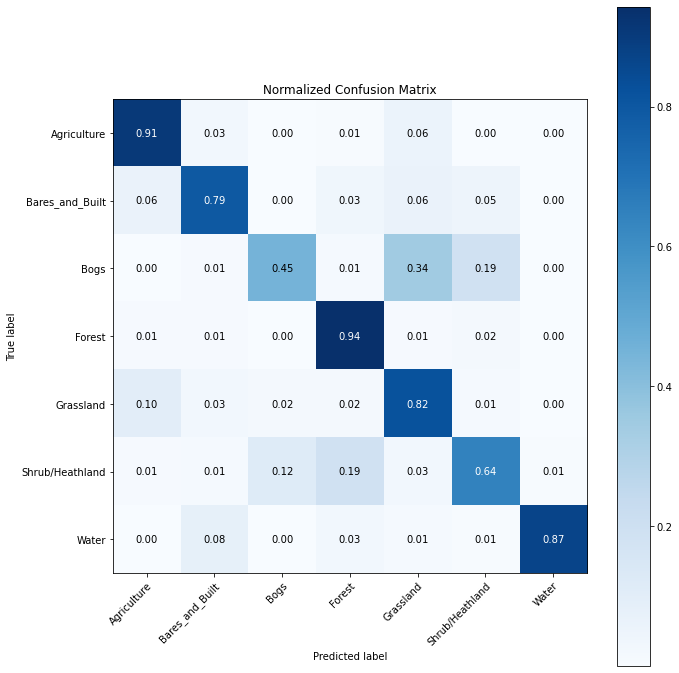

100%|██████████| 816/816 [00:09<00:00, 84.07it/s] 


[13:53:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




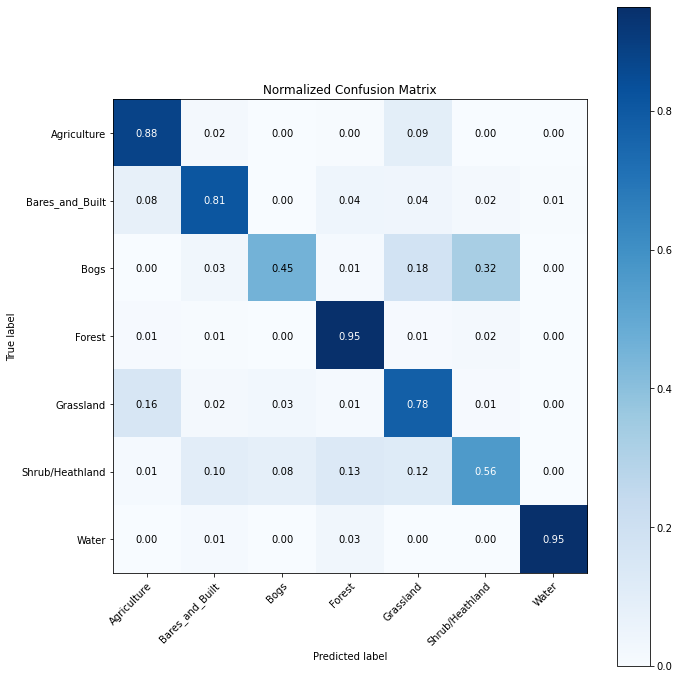

100%|██████████| 815/815 [00:08<00:00, 96.14it/s] 


[13:55:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




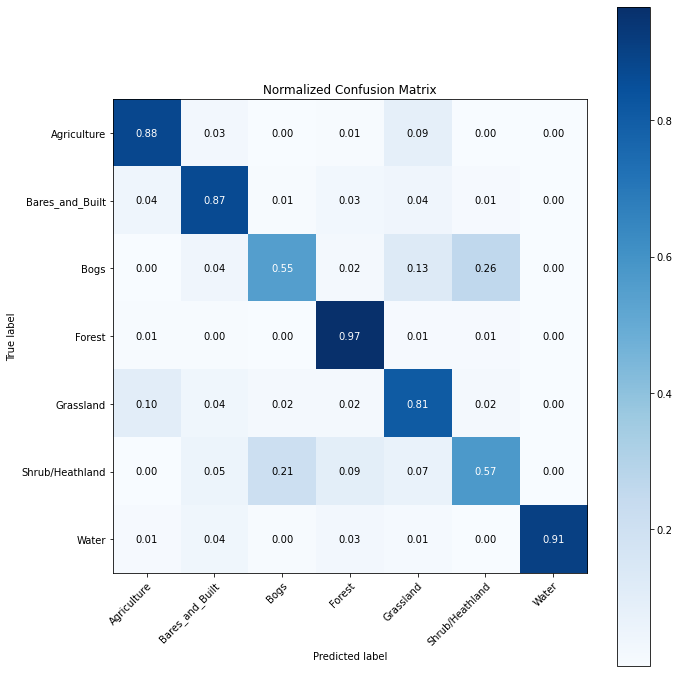

100%|██████████| 815/815 [00:08<00:00, 91.42it/s] 


[13:57:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




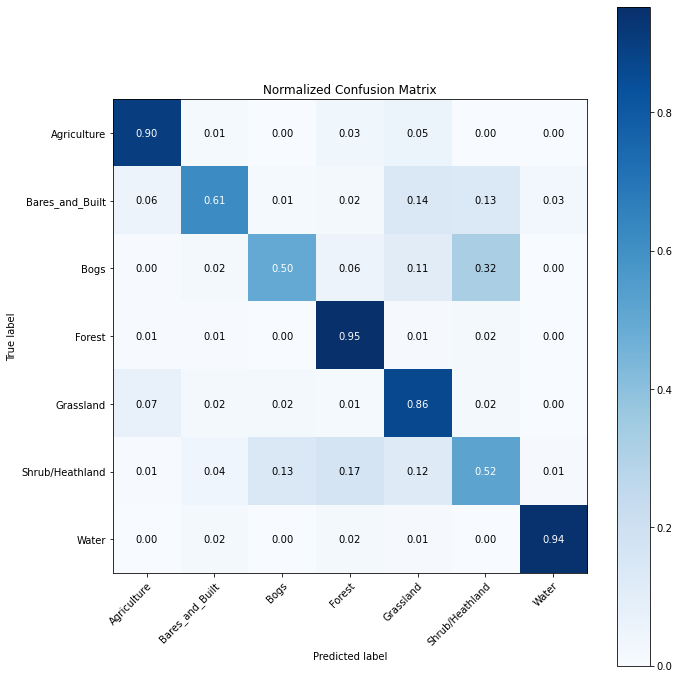

100%|██████████| 816/816 [00:08<00:00, 95.83it/s] 


[13:59:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




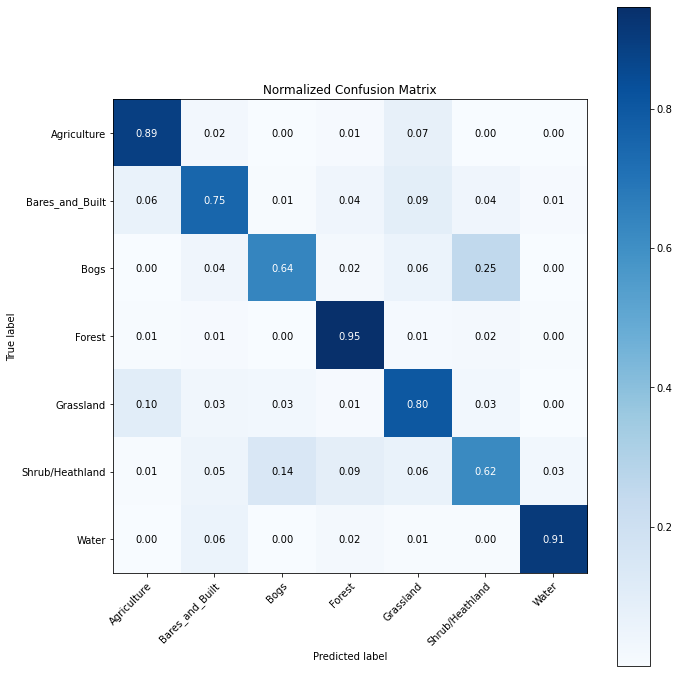

100%|██████████| 816/816 [00:09<00:00, 87.29it/s] 


[14:01:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




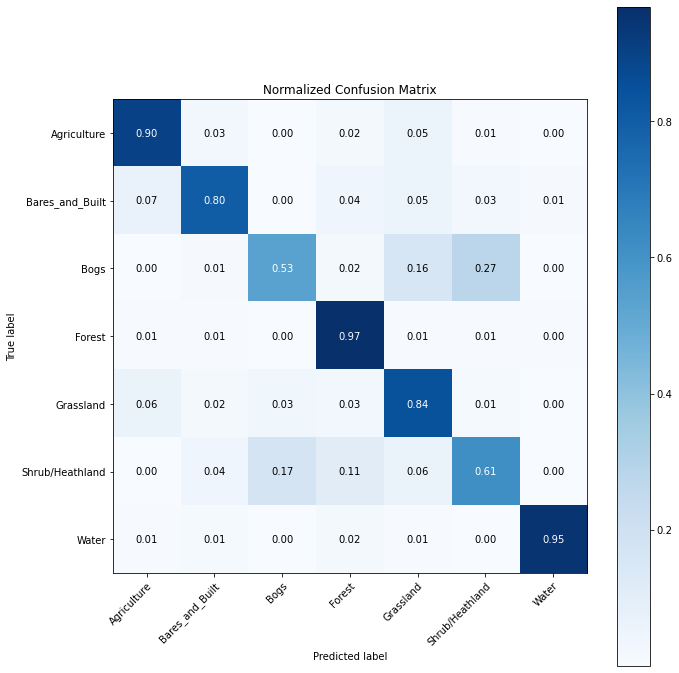

100%|██████████| 815/815 [00:09<00:00, 90.08it/s] 


[14:03:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




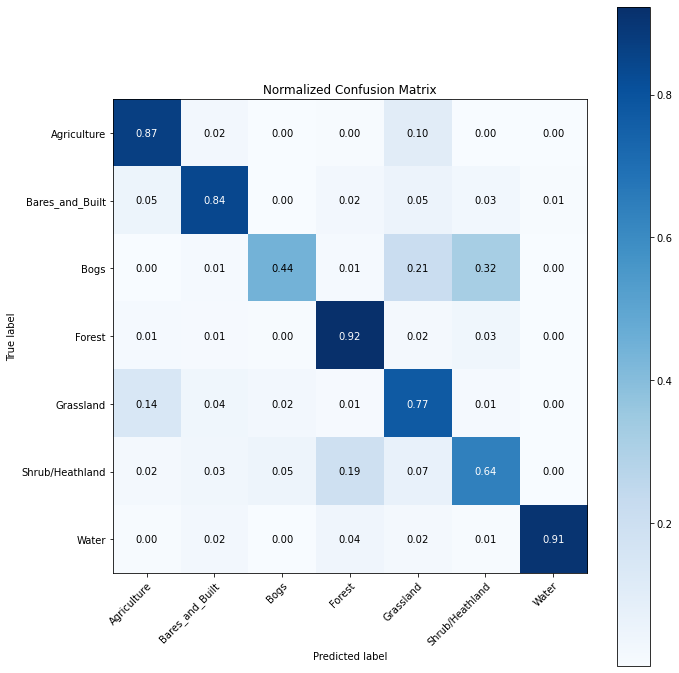

100%|██████████| 815/815 [00:08<00:00, 92.11it/s] 


[14:05:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




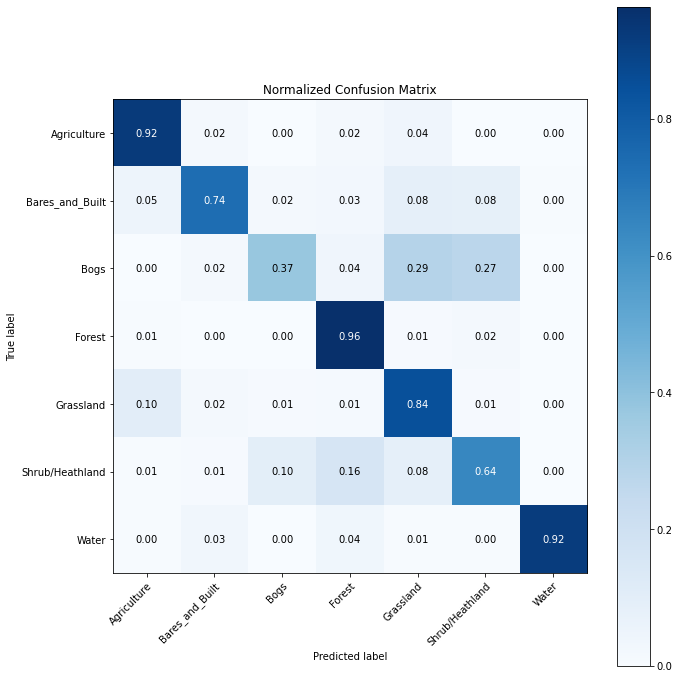

100%|██████████| 816/816 [00:09<00:00, 88.01it/s] 


[14:07:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




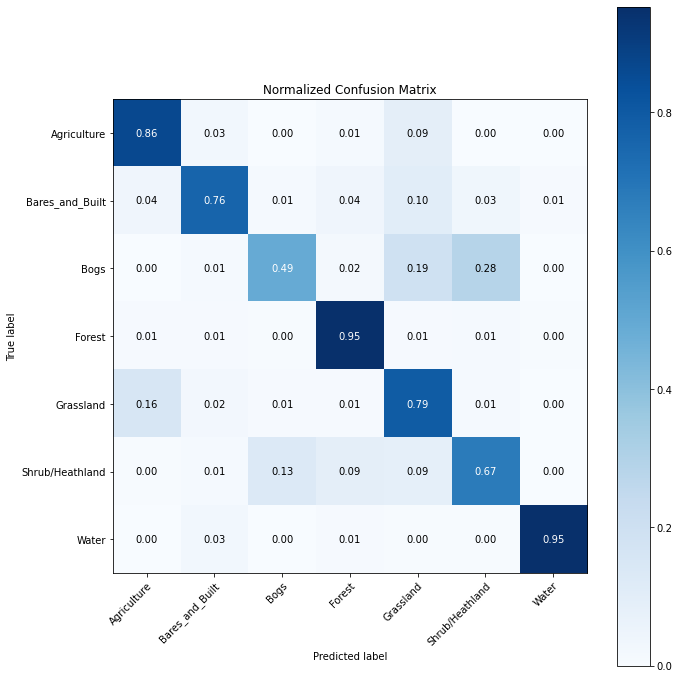

100%|██████████| 816/816 [00:09<00:00, 87.61it/s] 


[14:09:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




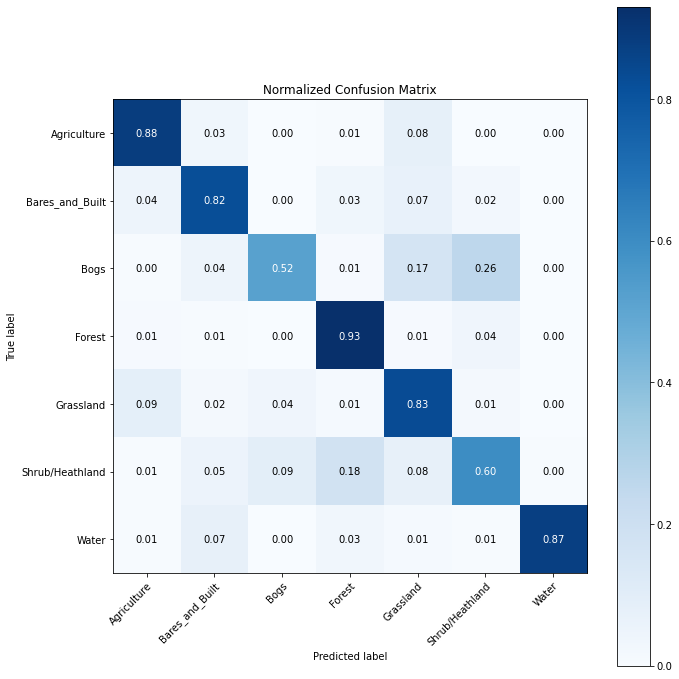

100%|██████████| 815/815 [00:09<00:00, 86.35it/s] 


[14:11:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




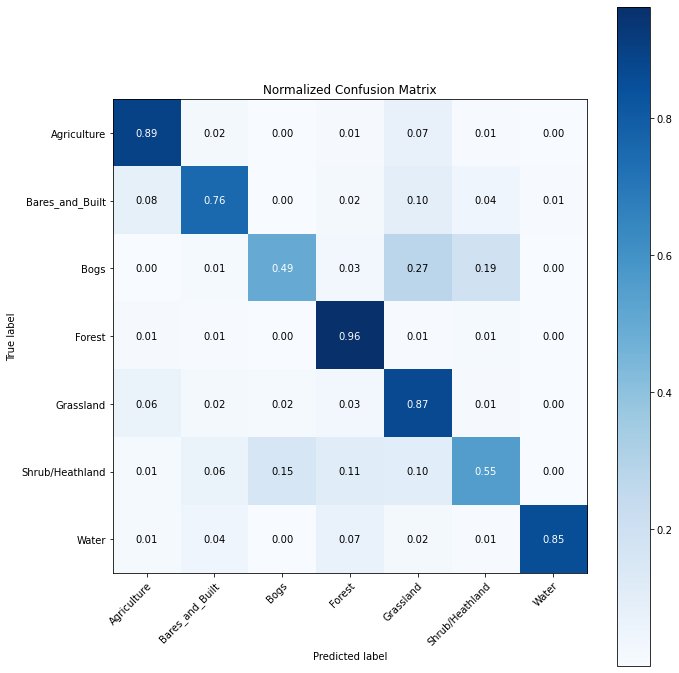

100%|██████████| 815/815 [00:09<00:00, 87.20it/s] 


[14:13:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight", "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




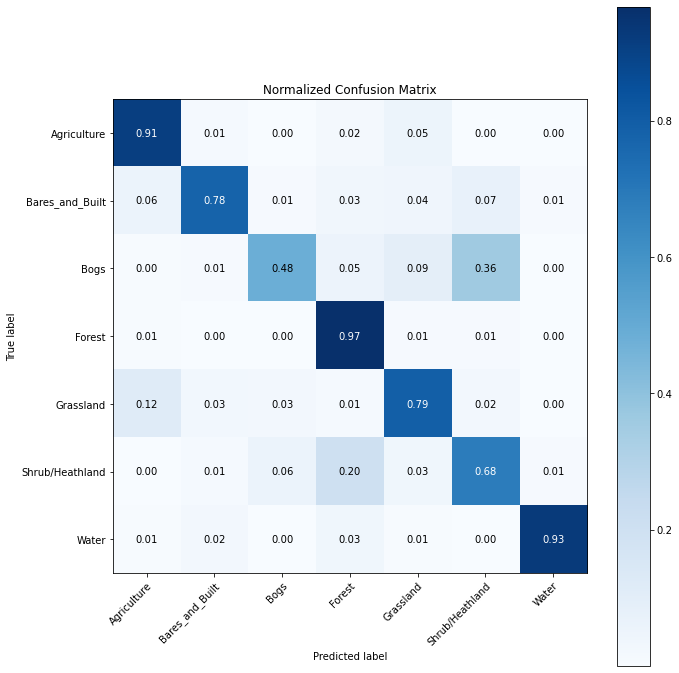

The mean accuracy is:0.8510347482097924
The mean balanced accuracy is:0.7751092631679157
The mean precision is:0.8508592840009694
The mean recall is:0.8510347482097924
The mean f1 score is:0.8494065709811951
FINAL MEAN CONFUSION MATRIX


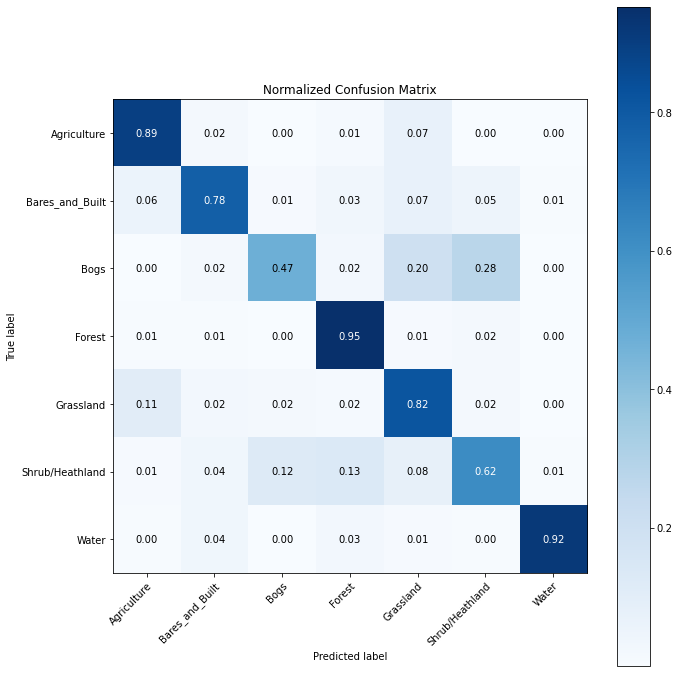

In [94]:
loops=10
for i in range(loops):
    
    results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm = xgb_cross_validate_ml(training_vectors,raster_path,class_dict,seed=i,folds=4)
    mean_accuracy.append(results_acc)
    mean_balanced_accuracy.append(results_bal_acc)
    mean_recall.append(results_recall)
    mean_prec.append(results_prec)
    mean_f1.append(results_f1)
    mean_cm.append(results_cm)

print(f'The mean accuracy is:{np.array(mean_accuracy).mean()}')
print(f'The mean balanced accuracy is:{np.array(mean_balanced_accuracy).mean()}')
print(f'The mean precision is:{np.array(mean_prec).mean()}')
print(f'The mean recall is:{np.array(mean_recall).mean()}')
print(f'The mean f1 score is:{np.array(mean_f1).mean()}')

# the final confusion matrix
final_sum_cm = np.zeros(mean_cm[0].shape)
for matrix in mean_cm:
   final_sum_cm +=matrix
final_mean_cm = final_sum_cm/loops

print('FINAL MEAN CONFUSION MATRIX')
plot_cm(final_mean_cm,classes)

In [95]:
mean_balanced_accuracy_df = pd.DataFrame(mean_balanced_accuracy,columns=['mean_balanced_accuracy'])
mean_balanced_accuracy_df.describe()

mean_balanced_accuracy
count               10.000000
mean                 0.775109
std                  0.005284
min                  0.767171
25%                  0.772853
50%                  0.774793
75%                  0.778968
max                  0.783944

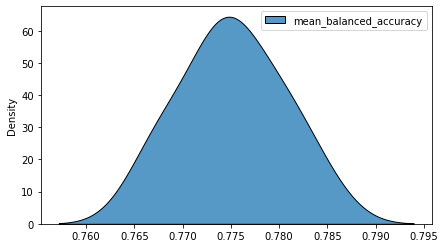

In [96]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=mean_balanced_accuracy_df, multiple="stack")
plt.show()

# Create Maps

In [ ]:
def create_map_ml(model,raster_image,raster_subimage_classifier,window_height,window_width,origin_x,origin_y,bands,add_ndvi_ndwi=False,raster_subimage=False):
    
    '''
    This function takes as an input a raster image and a pre-trained machine learning model and outputs a classification map.
    input: raster_image - path to the raster image
           raster_subimage - path to the subimage of the raster that would be created
           raster_subimage_classifier - path to the map related to the raster_subimage
           also the windows origin coordinates and whether to use gpu
           bands - number of bands for our image

    
    output: raster_subimage and raster_subimage_classifier <-- the map, to the chosen locations

    '''
    
    # load the raster image
    src = rasterio.open(raster_image, 'r')
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )

    # create the desired window
    window = rasterio.windows.Window(origin_x,origin_y,window_height,window_width)
    transform = rasterio.windows.transform(window, src.transform)

    # read the window and copy the meta of our raster
    data = src.read(window=window)
    meta = src.meta.copy()

    # convert our image from 2d array to a table
    data_reshaped = (data.reshape(bands,window_height*window_width)).T

    # check whether we like to add the ndvi and ndwi indexes
    if add_ndvi_ndwi == True:

        ndvi = band_index(data_reshaped, 3, 2)
        ndwi = band_index(data_reshaped, 1, 3)

        data_final = np.concatenate([data_reshaped, ndvi, ndwi], axis=1) 

    else:
        data_final = data_reshaped

    # generate our map
    map_predicted_np =  model.predict(data_final)

    # reshape the map 1d->2d
    map_predicted_final = map_predicted_np.reshape((1,window_height,window_width))

    # update the meta details
    meta['count']=1
    meta['height']=window_height
    meta['width']=window_width
    meta['dtype'] = 'int16'
    meta['transform'] = transform

    # save our classification map
    with rasterio.open(raster_subimage_classifier, 'w', **meta) as outds:
                outds.write(map_predicted_final)

    if raster_subimage != False:

            # change the meta for the raster
            meta['count'] = bands

            # save the the subraster image
            with rasterio.open(raster_subimage, 'w', **meta) as outds:
                        outds.write(src.read(window=window))

    src.close()

In [ ]:
raster_image = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/data/raster_file/big.tif'
raster_subimage_classifier = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/Maps/Scotland_Subraster_Classifier_LGB.tif'
bands = 13
window_height = 1024
window_width = 1024
origin_x = 2500
origin_y = 2500
model = lgbm

In [ ]:
create_map_ml(model,raster_image,raster_subimage_classifier,
             window_height,window_width,origin_x,origin_y,bands,add_ndvi_ndwi=False,raster_subimage=False)